In [52]:
import numpy as np
import jax.numpy as jnp
import re
import cupy as cp
import pickle
import time
import numpy as np
import jax.numpy as jnp
import pandas as pd
import numpy as np
import jax
import spacy
from tqdm import tqdm
from pathlib import Path
import json

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))


def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)  # Execute the wrapped function
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time
        # print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result

    return wrapper


def get_positional_encoding(seq_len, d_model):
    """
    Returns a non-learnable (sinusoidal) positional encoding.


    seq_len: Length of the input sequence.
    d_model: Dimension of the embeddings.
    """
    pos = cp.arange(seq_len)[:, cp.newaxis]  # Shape: [seq_len, 1]
    i = cp.arange(d_model)[cp.newaxis, :]  # Shape: [1, d_model]

    angle_rates = 1 / cp.power(10000, (2 * (i // 2)) / cp.float32(d_model))

    # Apply sine to even indices, cosine to odd indices
    pos_encoding = cp.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = cp.sin(pos * angle_rates[:, 0::2])  # sine on even indices
    pos_encoding[:, 1::2] = cp.cos(pos * angle_rates[:, 1::2])  # cosine on odd indices

    return pos_encoding


def softmax(x, axis=-1):
    # Subtract the max value for numerical stability
    e_x = cp.exp(x - cp.max(x, axis=axis, keepdims=True))
    return e_x / cp.sum(e_x, axis=axis, keepdims=True)








# @log_time
def pad_sequence(seq, max_len, pad_value=0):
    """Pad a sequence with a given value up to max_len."""
    current_len = seq.shape[0]
    pad_width = max_len - current_len
    if pad_width > 0:
        # Pad sequence with zeros (or any pad_value you provide)
        seq = cp.pad(seq, ((0, pad_width), (0, 0)), mode='constant', constant_values=pad_value)
    return seq


@log_time
def create_timestaped_input(input_d, words_per_phrase):
    input_translation = []
    for j in range(input_d.shape[0]):
        # Create padded sequences
        padded_sequences = [pad_sequence(input_d[j][0:i], words_per_phrase) for i in range(1, input_d.shape[1] + 1)]
        input_translation.append(padded_sequences)
    return cp.array(input_translation)

  
def redimension(X):
    return cp.concatenate(cp.swapaxes(X, 0, 1), axis=-1)

 
@log_time
def create_vocabulary(complete_text, name, nlp):
    # Use re.findall to split considering punctuation
    text = re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', complete_text)

    words_list = list(set(text))

    vocabulary = dict()

    for i, j in enumerate(words_list):
        # vocabulary[j]=(jax.random.uniform(jax.random.key(cp.random.randint(10000)),embedding_size),i)
        vocabulary[j] = (cp.array(nlp(j).vector), i)#(cp.random.rand(50), i)
        # print(j,len(cp.array(nlp(j).vector)))

    # print(vocabulary)
    # print("Vocabulary size: ", len(vocabulary))
    with open(f"data/{name}.pkl", 'wb') as handle:
        pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return vocabulary


@log_time
def pad_sequences(sentences, lenght, pad_token='[PAD]', target_type=None):
    """
    Pads the input sentences to have the same length by adding [PAD] tokens at the end.
    """

    if target_type == "encoder":
        # Split each sentence into words
        tokenized_sentences = [["[START]"] + re.findall(r'\[.*?\]|\w+|[^\w\s]\n', sentence) + ["[END]"] for sentence in
                               sentences]
    elif target_type == "decoder":
        tokenized_sentences = [["[START]"] + re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', sentence) for sentence in sentences]
    elif target_type == "target":
        tokenized_sentences = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', sentence) + ["[END]"] for sentence in sentences]
    # print(tokenized_sentences)
    if lenght == 0:
        # Find the maximum sentence length
        max_len = max(len(sentence) for sentence in tokenized_sentences)
    else:
        max_len = lenght

    # Pad each sentence with the [PAD] token to make them of equal length
    padded_sentences = [" ".join(sentence + [pad_token] * (max_len - len(sentence))) for sentence in
                        tokenized_sentences]

    return padded_sentences

def print_matrix(X):
    for i in X:
        print(i)
@log_time
def create_decoder_target(y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):

    decoder_input = pad_sequences(y_train, lenght=max_words_per_phrase, target_type="target")
    #print_matrix(decoder_input)
    decoder_input = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', i) for i in decoder_input]
    
    if max_words_per_phrase == None:
        max_words_per_phrase = len(decoder_input[0])

    phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
    # for sentence in phrase_vectors_y:
    #     print(sentence)
    #print_matrix(phrase_vectors_y)
    

    yi = cp.array([[get_one_hot(word,vocabulary_decoder) for word in phrase_vector] for phrase_vector in phrase_vectors_y]) 
     
    return yi
@log_time
def generate_input_encoder(x_batch, vocabulary_encoder, max_words_per_phrase):

    x_train = pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")# here are string
    
    xi = [] 
    phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train] 
    phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x] 
    #print("x batch",phrase_vectors_x)
    xi = cp.array([[vocabulary_encoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_x])

    return xi


# @log_time
def update_wembedding_encoder(x_batch, inputs_e, vocabulary, max_words_per_phrase):
    x_train = pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")
    # print(x_train)

    phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]

    phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x]
    # print("inputs_e",inputs_e.shape)
    # print("(phrase_vectors_x).shape:\n",cp.array(phrase_vectors_x).shape)

    for phrase in range(inputs_e.shape[0]):
        # print(phrase)
        for position, word in enumerate(phrase_vectors_x[phrase]): 
            vocabulary[word] = (inputs_e[phrase][position], vocabulary[word][1])

    return vocabulary


# @log_time
def update_wembedding_decoder(y_batch, inputs_decoder, max_words_per_phrase, vocabulary):
    # print("inputs_decoder",inputs_decoder.shape)
    decoder_input = pad_sequences(y_batch, lenght=max_words_per_phrase, target_type="decoder")
    decoder_input = [i.split() for i in decoder_input]
    # print(max_words_per_phrase)
    if max_words_per_phrase == None:
        max_words_per_phrase = len(decoder_input[0])

    phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
    # for sentence in phrase_vectors_y:
    #     print(sentence)
    for phrase in range(inputs_decoder.shape[0]):
        # print(phrase)
        for position, word in enumerate(phrase_vectors_y[phrase]): 
            vocabulary[word] = (inputs_decoder[phrase][position], vocabulary[word][1])

    return vocabulary


@log_time
def create_input_encoder(X, vocabulary_encoder, max_words_per_phrase, embedding_size):

    pos_encoding = get_positional_encoding(max_words_per_phrase, embedding_size)
    #print(pos_encoding)
    inputs_e = generate_input_encoder(X, vocabulary_encoder, max_words_per_phrase)
    
    #print(inputs_e)

    inputs_e += pos_encoding
    return inputs_e


@log_time
def create_decoder_input(y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):
    decoder_input = pad_sequences(y_train, lenght=max_words_per_phrase, target_type="decoder")
    #print_matrix(decoder_input)
    decoder_input = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', i) for i in decoder_input]
    
    if max_words_per_phrase == None:
        max_words_per_phrase = len(decoder_input[0])

    phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
    # for sentence in phrase_vectors_y:
    #     print(sentence)
    #print_matrix(phrase_vectors_y)
    

    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
    
    pos_encoding = get_positional_encoding(max_words_per_phrase, embedding_size)
    # print(pos_encoding.shape,yi.shape)
    yi = yi + pos_encoding
    #print_matrix(yi)
    # decoder_inputs = cp.array(cp.swapaxes(create_timestaped_input(yi, max_words_per_phrase), 0, 1))
    
    # # decoder_inputs[zero_rows] = vocabulary_decoder["[PAD]"][0]
    # for i in range(decoder_inputs.shape[0]):
    #     for j in range(decoder_inputs[i].shape[0]):
    #         zero_rows = cp.all(decoder_inputs[i][j] == 0, axis=1)

    #         decoder_inputs[i][j][zero_rows] =cp.zeros(embedding_size)# vocabulary_decoder["[PAD]"][0]

    # decoder_inputs = cp.array(decoder_inputs)
    #print(decoder_inputs[2])
    #print(decoder_inputs)
    return  yi




 

def bucket_by_length(x_train, y_train, batch_size):
    # Pair x_train and y_train together
    paired_data = list(zip(x_train, y_train))

    # Sort the pairs by the length of the x_train phrases
    paired_data_sorted = sorted(paired_data, key=lambda pair: len(pair[1]))

    # Initialize buckets for x_train and y_train
    x_batches = []
    y_batches = []

    # Group phrases into batches of batch_size
    for i in range(0, len(paired_data_sorted), batch_size):
        batch = paired_data_sorted[i:i + batch_size]

        # Split the batch back into x_train and y_train
        x_batch, y_batch = zip(*batch)

        x_batches.append(list(x_batch))
        y_batches.append(list(y_batch))

    return x_batches, y_batches


def pad_inputs(sentences, target_type):
    if target_type == "encoder":
        tokenized_sentences = [['[START]'] + sentence + ['[END]'] for sentence in sentences]
    elif target_type == "decoder":
        tokenized_sentences = [["[START]"] + sentence for sentence in sentences]
    elif target_type == "target":
        tokenized_sentences = [sentence + ["[END]"] for sentence in sentences]
    return tokenized_sentences


def generate_inputs(sentences, vocabulary, pad_token='[PAD]', target_type=None):
    """
    Pads the input sentences to have the same length by adding [PAD] tokens at the end.
    """

    tokenized_sentences = pad_inputs(sentences, target_type)
    max_len = max(len(sentence) for sentence in tokenized_sentences)
    # Pad each sentence with the [PAD] token to make them of equal length
    padded_sentences = [sentence + [pad_token] * (max_len - len(sentence)) for sentence in tokenized_sentences]

    # print(padded_sentences)
    xi = cp.array([[vocabulary[word][0] for word in phrase_vector] for phrase_vector in padded_sentences])
    # print(xi.shape)
    pos_encoding = get_positional_encoding(max_len, 300)
    xi += pos_encoding

    if target_type == "decoder":
        xi = cp.array(cp.swapaxes(create_timestaped_input(xi, max_len), 0, 1))

    return xi


def forward_attention_encoder(inputs_e,Qe, Ke, Ve, num_heads, batch_size, dk):
    

    Q_E = cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_e, Qe), num_heads, axis=2)), 0, 1)
    # print("Qval.shape: ",Q_E.shape)

    K_E = cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_e, Ke), num_heads, axis=2)), 0, 1)
    # print("Kval.shape: ",K_E.shape)

    V_E = cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_e, Ve), num_heads, axis=2)), 0, 1)
    # print("Vval.shape: ",V_E.shape)

    QKscaled = cp.matmul(Q_E, cp.transpose(K_E, (0, 1, 3, 2))) / cp.sqrt(dk)

    Attention_weights_e = softmax(QKscaled)
    # print("Attention_weights shape:",Attention_weights_e.shape)

    Ae = cp.matmul(Attention_weights_e, V_E)
    # print("Attention shape:",Ae.shape)

    Ae = cp.array([cp.concatenate(Ae[i], axis=1) for i in range(batch_size)])
    # print("Attention encoder shape concat:",Ae.shape)

    return Ae, Attention_weights_e, K_E, V_E, Q_E

import cupy as cp

def compute_derivative_A(X, mu,sqrVar,sqrVar_3_2):
     
    A=1 /sqrVar
     
    B=X*(X-mu)
    
    result=A-(B/sqrVar_3_2)
    return result


def compute_derivative_B(X, mu,sqrVar,N,sqrVar_3_2):
   
    A=-1/(N*sqrVar)

    B=mu*(X-mu)
    
    result=A+(B/sqrVar_3_2)
    #print(A)
    return result

def diff_norm(X, var, mu, N,epsilon=1e-6): 
     
    sqrVar=cp.sqrt(var+epsilon)
    sqrVar_3_2=N*((var + epsilon) ** (3 / 2))
 
    A=compute_derivative_A(X, mu, sqrVar,sqrVar_3_2)
    B=compute_derivative_B(X, mu,sqrVar,N,sqrVar_3_2)
    result=A+B
    return result




class layer_normalization: 
    def __init__(self,epsilon):
        self.epsilon=epsilon
        self.mu=0
        self.var=0
        self.N=0
        pass

    def forward(self,x):
        self.X=x
        self.mu = cp.mean(x, axis=-1, keepdims=True)
        self.var = cp.var(x, axis=-1, keepdims=True) 
        self.N=x.shape[-1]
        x_norm = (x - self.mu) / cp.sqrt(self.var + self.epsilon)  
        return x_norm
    
    def compute_derivative_A(self,X, mu,sqrVar,sqrVar_3_2):
        A=1 /sqrVar
        B=X*(X-mu)
        result=A-(B/sqrVar_3_2)
        return result
    
    def compute_derivative_B(self,X, mu,sqrVar,N,sqrVar_3_2):
        A=-1/(N*sqrVar)
        B=mu*(X-mu)
        result=A+(B/sqrVar_3_2)
        return result
    
    def backpropagation(self):
        sqrVar=cp.sqrt(self.var+self.epsilon)
        sqrVar_3_2=self.N*((self.var + self.epsilon) ** (3 / 2)) 
        A=compute_derivative_A(self.X, self.mu, sqrVar,sqrVar_3_2)
        B=compute_derivative_B(self.X, self.mu,sqrVar,self.N,sqrVar_3_2)
        result=A+B
        return result

class linear_layer: 
    def __init__(self,input_size,output_size,out=False):
        if out==True:
            self.W=cp.random.rand(input_size, output_size)/cp.sqrt(input_size)
        else:
            self.W=cp.random.rand(input_size, output_size) 
        self.b=cp.random.rand(output_size)
      
    def forward(self,X): 
        self.X=X
        Xout = cp.matmul(X, self.W) + self.b 
        return Xout
    
    def forward_weights_only(self,X): 
        self.X=X
        Xout = cp.matmul(X, self.W) 
        return Xout
    
    def dW(self): 
        return self.X
    
    def db(self): 
        return 1
    
    def update_weights(self,dLoss_dW,dLoss_db,learning_rate):
        self.W=self.W-learning_rate*dLoss_dW
        self.b=self.b-learning_rate*dLoss_db

    def update_weights_only(self,dLoss_dW,learning_rate):
        self.W=self.W-learning_rate*dLoss_dW
       

class ReLu_layer:
    def __init__(self,alpha):
        self.alpha=alpha
         
    
    def forward_leaky(self,X):
        self.X=X
        return cp.where(X > 0, X, self.alpha * X)

    def forward(self,X): 
        self.X=X
        return cp.maximum(0,self.X)
    
    def backward(self, dLoss): 
        # Gradient of ReLU is 1 for x > 0, else 0
        dx = dLoss * (self.X > 0)  # Only propagate gradients for inputs > 0
        return dx
    
    def backward_leaky(self, dLoss): 
        dx = dLoss * cp.where(self.X > 0, 1, self.alpha)  # Gradient: 1 for x > 0, else alpha
        return dx


def layer_norm(x, epsilon=1e-6): 
    # Calculate the mean and variance
    mean = cp.mean(x, axis=-1, keepdims=True)
    var = cp.var(x, axis=-1, keepdims=True) 
    x_norm = (x - mean) / cp.sqrt(var + epsilon) 
    return x_norm, mean, var, x.shape[-1]


def residual_and_norm(Ae, inputs_e):
    Xe = Ae + inputs_e
    Ect1, mu_e, var_e, Ne = layer_norm(Xe)
    # print("Ect1.shape",Ect1.shape,Ne)
    return Ect1, Xe, mu_e, var_e, Ne


def leaky_relu(X, alpha=0.01):
    return cp.where(X > 0, X, alpha * X)

def relu(X): 
    return cp.max(0,X)
def relu_backward(dA, Xd1,alpha=0.01):
    # Create mask where Xd1 > 0
    relu_mask = (Xd1 > 0).astype(float)  # This will give 1 where Xd1 > 0, else 0
    # Multiply the incoming gradient dA by the mask
    dXd1 = dA * np.where(Xd1 > 0, 1,alpha)
    return dXd1

def fully_connected_layers_encoder(Ect1,Wfl1e, bfl1e, Wfl2e, bfl2e): 
    Xe1 = cp.matmul(Ect1, Wfl1e) + bfl1e
    FLe1 = leaky_relu(Xe1)
    FLe1=dropout(FLe1, dropout_rate=0.1, training=True)
    FLe2 = cp.matmul(FLe1, Wfl2e) + bfl2e
    Xe2 = FLe2 + Ect1
    Ecout, mu_e2, var_e2, N_e2 = layer_norm(Xe2)
    return Ecout,mu_e2,var_e2,N_e2,FLe1,Xe1,Xe2
    
     

 

def cross_attention_encoder(Ecout):
    global Kc, Vc
    K_C = cp.swapaxes(cp.array(cp.array_split(cp.matmul(Ecout, Kc), num_heads, axis=2)), 0, 1)
    # print("K_C.shape: ",K_C.shape)# shape is: num_phrases, numbheads, words_per_phrase, dv/num_heads
    V_C = cp.swapaxes(cp.array(cp.array_split(cp.matmul(Ecout, Vc), num_heads, axis=2)), 0, 1)
    # print("V_C.shape: ",V_C.shape)
    return K_C, V_C

class multihead_attention: 
    def __init__(self,num_heads,dk,batch_size):
        self.num_heads=num_heads
        self.dk=dk
        self.batch_size=batch_size
        
    def reshape_heads(self,Q,K,V):
        self.Q = cp.swapaxes(cp.array(cp.array_split(Q, self.num_heads, axis=2)), 0, 1)
        # print("Qval.shape: ",Q_E.shape)
        self.K = cp.swapaxes(cp.array(cp.array_split(K, self.num_heads, axis=2)), 0, 1)
        # print("Kval.shape: ",K_E.shape)
        self.V = cp.swapaxes(cp.array(cp.array_split(V, self.num_heads, axis=2)), 0, 1)
        return self.Q,self.K,self.V

    def attention_weights(self):
        QKscaled = cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.dk) 
        self.Attention_weights = softmax(QKscaled)
         

    def attention(self):
        self.attention_weights()
        Ae = cp.matmul(self.Attention_weights, self.V)
        # print("Attention shape:",Ae.shape)
        Ae = cp.array([cp.concatenate(Ae[i], axis=1) for i in range(self.batch_size)])
        # print("Attention encoder shape concat:",Ae.shape)
        return Ae
    
    def masked_attention(self,mask_size):
        self.attention_weights_masked(mask_size)
        Ae = cp.matmul(self.Attention_weights, self.V)
         
        Ae = cp.array([cp.concatenate(Ae[i], axis=1) for i in range(self.batch_size)])
        # print("Attention encoder shape concat:",Ae.shape)
        return Ae
    
    def attention_weights_masked(self,mask_size):
        #mask_size =  words_per_phrase 

        QKscaled = cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.dk)
         
        mask = cp.tril(cp.ones((mask_size, mask_size)))  # (9, 9) lower triangular matrix
        mask[mask == 0]=-cp.inf  # Set future tokens to -inf
        mask[mask == 1]=0  # Set allowed tokens to 0
         
        mask = mask.reshape(1, 1, mask_size, mask_size)
        QKscaled = QKscaled + mask

        self.Attention_weights = softmax(QKscaled)
         
    
    def diffQi(self,dAttention,X):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_dX=cp.transpose(dAttention, (0, 2, 1)) @ (redimension(dAttention_weights @ (self.K * self.V) / cp.sqrt(self.dk))*X)
        return cp.sum(dLoss_dX,axis=0)
    
    def diffKi(self,dAttention,X):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        X = cp.swapaxes(cp.array(cp.array_split(X, self.num_heads, axis=2)), 0, 1) 
         
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ redimension(
            (dAttention_weights * (self.Q @ cp.transpose(self.V, (0, 1, 3, 2))) @ X) / cp.sqrt(self.dk)) 
        return cp.sum(dLoss_dX,axis=0)
    
    def diffVi(self,dAttention,X):
        dLoss_Vc = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ (
                self.Attention_weights @ cp.expand_dims(X, axis=1)), axis=1), axis=0)
        return dLoss_Vc
    
    def diffKInput(self,dAttention,Ki):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_KI=dAttention*(redimension(dAttention_weights @ self.Q / cp.sqrt(self.dk))*redimension(self.V)@Ki)
        return dLoss_KI
    
    def diffVInput(self,dAttention,Vi):
        dLoss_V_E = cp.transpose(
        cp.mean(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ self.Attention_weights, axis=1), (0, 2, 1))
        dLoss_inpute_v = dLoss_V_E @ Vi
        return dLoss_inpute_v
    
    def diffQInput(self,dAttention,Qi):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_KI=dAttention*(redimension(dAttention_weights @ self.K / cp.sqrt(self.dk))*redimension(self.V)@Qi)
        return dLoss_KI


def derivative_input_encoder(dLoss_Ae, Attention_weights_e, K_E, V_E, Q_E, dLoss_inpute_a, inputs_e,Ve, Qe, Ke, dk):
    

    dLoss_V_E = cp.transpose(
        cp.mean(cp.transpose(cp.expand_dims(dLoss_Ae, axis=1), (0, 1, 3, 2)) @ Attention_weights_e, axis=1), (0, 2, 1))
    dLoss_inpute_v = dLoss_V_E @ Ve

    dAttention_weights_e = Attention_weights_e * (1 - Attention_weights_e)
    V1 = redimension(dAttention_weights_e @ K_E / cp.sqrt(dk))
    V2 = redimension(V_E)
    V3 = V1 * V2
    dLoss_Q_E = dLoss_Ae * V3
    dLoss_inpute_q = dLoss_Q_E @ Qe
    # print("dLoss_inpute_q.shape",dLoss_inpute_q.shape)

    V1 = redimension(dAttention_weights_e @ Q_E / cp.sqrt(dk))
    V2 = redimension(V_E)
    V3 = V1 * V2
    dLoss_K_E = dLoss_Ae * V3
    dLoss_inpute_k = dLoss_K_E @ Ke
    # print("dLoss_inpute_k.shape",dLoss_inpute_k.shape)
    dLoss_inpute = dLoss_inpute_a + dLoss_inpute_k + dLoss_inpute_q + dLoss_inpute_v
    dLoss_dWemb_encoder = dLoss_inpute * inputs_e
    return dLoss_inpute, dLoss_dWemb_encoder

def diffQKV(dAttention, Attention_weights, X1, X2, X3, dk, matrix=""):
    global num_heads 
    dAttention_weights = Attention_weights * (1 - Attention_weights) 
    if matrix != "k":
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ (
                    redimension(dAttention_weights @ (X1 * X2) / cp.sqrt(dk)) * X3)
    else: 
        X3 = cp.swapaxes(cp.array(cp.array_split(X3, num_heads, axis=2)), 0, 1) 
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ redimension(
            (dAttention_weights * (X1 @ cp.transpose(X2, (0, 1, 3, 2))) @ X3) / cp.sqrt(dk)) 
    return dLoss_dX

########################################################DECODER
def forward_attention_decoder(input_decoder):
    global Qd, Kd, Vd  # ,words_per_phrase

    Q_D = cp.swapaxes(cp.array(cp.array_split(cp.matmul(input_decoder, Qd), num_heads, axis=2)), 0, 1)
    # print("Qval.shape: ",Q_D.shape)# numwords, num_phrases, numheads, num_words, dv/num_heads

    # K_D  = cp.swapaxes(cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_d[step], Kd),num_heads,axis=3)), 0, 1),1,2)
    K_D = cp.swapaxes(cp.array(cp.array_split(cp.matmul(input_decoder, Kd), num_heads, axis=2)), 0, 1)
    # print("Kval.shape: ",K_D.shape)

    # V_D  = cp.swapaxes(cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_d[step], Vd),num_heads,axis=3)), 0, 1),1,2)
    V_D = cp.swapaxes(cp.array(cp.array_split(cp.matmul(input_decoder, Vd), num_heads, axis=2)), 0, 1)

    QKscaled_decoder = cp.matmul(Q_D, cp.transpose(K_D, (0, 1, 3, 2))) / cp.sqrt(dv)
    # Step 1: Create a causal mask of shape (1, 1, 9, 9) to broadcast across heads and batch
    mask_size = input_decoder.shape[1]  # words_per_phrase
    # print(mask_size)
    mask = cp.tril(cp.ones((mask_size, mask_size)))  # (9, 9) lower triangular matrix
    mask[mask == 0]=-cp.inf  # Set future tokens to -inf
    mask[mask == 1]=0  # Set allowed tokens to 0
    mask = mask.reshape(1, 1, mask_size, mask_size)

    # Step 2: Apply mask to QKscaled_decoder (it will broadcast across batch and heads)
    QKscaled_decoder = QKscaled_decoder + mask

    Attention_weights_masked = softmax(QKscaled_decoder)

    A_mask = cp.matmul(Attention_weights_masked, V_D)
    # print("A_mask.shape non concat: ",A_mask.shape)

    # A_mask=cp.swapaxes(cp.concatenate(cp.swapaxes(A_mask,0,2),axis=-1),0,1)
    A_mask = cp.concatenate(cp.swapaxes(A_mask, 0, 1), axis=-1)

    # print("A_mask.shape concat: ",A_mask.shape)
    # print("inputs_d.shape: ",input_decoder.shape)
    # print("Dt1.shape: ",Dt1.shape)
    return A_mask, Attention_weights_masked, Q_D, K_D, V_D


def decoder_first_residual_and_norm(A_mask, input_decoder):
    Xd = input_decoder + A_mask
    Dt1, mu_d, var_d, N_d = layer_norm(Xd)
    return Xd, Dt1, mu_d, var_d, N_d


def cross_attention_decoder(Dt1):
    global Qc
    Q_C = cp.swapaxes(cp.array(cp.array_split(cp.matmul(Dt1, Qc), num_heads, axis=2)), 0, 1)
    # print("Q_C.shape: ",Q_C.shape)
    return Q_C


def cross_attention(Q_C, K_C, V_C, Dt1):
    global dv
    # print("Q_C.shape",Q_C.shape)
    # print("K_C.shape",K_C.shape)
    # print("V_C.shape",V_C.shape)
    QKscaled_cross_attention = cp.matmul(Q_C, cp.transpose(K_C, (0, 1, 3, 2))) / cp.sqrt(dv)
    Attention_weights_cross = softmax(QKscaled_cross_attention)
    Acr = cp.matmul(Attention_weights_cross, V_C)
    # print("Acr.shape non concat",Acr.shape)
    Acr = cp.concatenate(cp.swapaxes(Acr, 0, 1), axis=-1)
    # print("Acr.shape concat",Acr.shape)

    return Acr, Attention_weights_cross


def cross_attention_residual_and_norm(Acr, Dt1):
    Res = Acr + Dt1
    Dt2, mu_res, var_res, N_res = layer_norm(Res)
    return Dt2, mu_res, var_res, N_res, Res


def fully_connected_layers_decoder(Dt2):
    global Wfl1d, bfl1d, Wfl2d, bfl2d, num_phrases

    Xd1 = cp.matmul(Dt2, Wfl1d) + bfl1d
    num_zeros = cp.sum(Xd1 == 0)
    #print(f"Number of zeros in the input: {num_zeros}")
    FLd1 = leaky_relu(Xd1)
    num_zeros = cp.sum(FLd1 == 0)
       
    #print(f"Number of zeros in the output: {num_zeros}")

    FLd1=dropout(FLd1, dropout_rate=0.1, training=True)

    FLd2 = cp.matmul(FLd1, Wfl2d) + bfl2d
    # print("FLd2.shape",FLd2.shape)

    Xd2 = FLd2 + Dt2


    Dout, mu_d2, var_d2, N_d2 = layer_norm(Xd2)

    print("Dout.shape",Dout.shape)
    #Dout = Dout.reshape(Dout.shape[0], Dout.shape[1] * Dout.shape[2])
    #Dout = Dout[.reshape(Dout.shape[0], Dout.shape[1] * Dout.shape[2])]
    # print("Dout.shape",Dout.shape)
    return Dout, mu_d2, var_d2, N_d2, Xd2, Xd1, FLd1


def output_layer(Dout):
    global Wo, bo

    Zout = cp.matmul(Dout, Wo) + bo

    SigmaZout = softmax(Zout)
    # print("SigmaZout.shape",SigmaZout.shape)

    return SigmaZout


def loss_calculation(SigmaZout, target):
    # print("target.shape",cp.array(target).shape)
    Loss = cross_entropy_loss(SigmaZout, target)
    # print("Loss:",Loss)
    return Loss

def dropout(X, dropout_rate=0.1, training=True): 

    #print("X.shape",X.shape)

    if training:
        # Create a mask
        mask = cp.random.rand(*X.shape) > dropout_rate

        #print(X.shape,X.size)
        #print("mask.shape",mask.shape)
        result = X * mask / (1 - dropout_rate)  # Scale output
        
        # Count the number of zeros
        num_zeros = cp.sum(mask == 0)
        num_zeros1 = cp.sum(X == 0)
        
        # Calculate expected number of zeros
        expected_zeros = int(dropout_rate * mask.size)  # Total elements
        #print(f"Number of zeros in the output: {num_zeros}, Expected: {expected_zeros},{num_zeros1}")


        # # Debugging information
        # print("result.shape",result.shape)
         

        return result
    else:
        return X  # Return as-is during evaluation

##################################################################BACKPROPAGATION
def derivate_dout(SigmaZout, target, Dout):

    global bo,Wo, embedding_size, batch_size, words_per_phrase
    dLoss_dZout = SigmaZout - target
    print("dLoss_dZout.shape",dLoss_dZout.shape)
    dLoss_W0 = cp.transpose(dLoss_dZout, (1, 0)) @ Dout
    print("dLoss_W0.shape",dLoss_W0.shape,"W0.shape",Wo.shape)
    dLoss_b0 = cp.sum(dLoss_dZout, axis=0)
    print("dLoss_b0.shape",dLoss_b0.shape,"b0.shape",bo.shape)
    dLoss_Dout = dLoss_dZout @ Wo.T
    #dLoss_Dout = dLoss_Dout.reshape(batch_size, words_per_phrase, embedding_size)
    print("dLoss_Dout.shape",dLoss_Dout.shape)
    return dLoss_dZout, dLoss_Dout, dLoss_W0, dLoss_b0



 
def derivate_fully_connected_layers_decoder(dLoss_Dout, Dt2, Xd2, var_d2, mu_d2, N_d2, FLd1, Xd1):
    global Wfl1d, Wfl2d

    dLoss_FLd2 = dLoss_Dout * diff_norm(Xd2, var_d2, mu_d2, N_d2)
    # print("dLoss_FLd2.shape",dLoss_FLd2.shape)
    dLoss_Dt2_a = dLoss_FLd2
    # print("dLoss_Dt2_a.shape",dLoss_Dt2_a.shape)
    # print("Dt2.shape",Dt2.shape)
    dLoss_FLd1 = dLoss_FLd2 @ cp.transpose(Wfl2d, (1, 0))
    # print("dLoss_FLd1.shape",dLoss_FLd1.shape)
    # print("FLd1.shape",FLd1.shape)
    dLoss_Wfl2d = cp.sum(cp.transpose(dLoss_FLd2, (0, 2, 1)) @ FLd1, axis=0).T
    # print("dLoss_Wfl2d.shape",dLoss_Wfl2d.shape) # do the mean here over each phrase
    # print("Wfl2d.shape",Wfl2d.shape)
    dLoss_bfl2d = cp.sum(cp.sum(dLoss_FLd2, axis=0), axis=0)
    # print("dLoss_bfl2d.shape",dLoss_bfl2d.shape) # do the mean here over each phrase
    # print("bfl2d.shape",bfl2d.shape)

    DLoss_Dt2_b = relu_backward(dLoss_FLd1, Xd1) @ cp.transpose(Wfl1d, (1, 0))
    DLoss_Dt2 = dLoss_Dt2_a + DLoss_Dt2_b
    # print("DLoss_Dt2.shape",DLoss_Dt2.shape) # do the mean here over each phrase
    # print("Dt2.shape",Dt2.shape)

    dLoss_Wfl1d = cp.sum(cp.transpose(relu_backward(dLoss_FLd1, Xd1), (0, 2, 1)) @ Dt2, axis=0).T
    # print("dLoss_Wfl1d.shape",dLoss_Wfl1d.shape) # do the mean here over each phrase
    # print("Wfl1d.shape",Wfl1d.shape)

    dLoss_bfl1d = cp.sum(cp.sum(relu_backward(dLoss_FLd1, Xd1), axis=0), axis=0)

    return dLoss_Wfl2d, dLoss_bfl2d, dLoss_Wfl1d, dLoss_bfl1d, DLoss_Dt2


def derivative_cross_attention(dLoss_Dt2, Res, var_res, mu_res, N_res, Attention_weights_cross, K_C, V_C, Q_C, Ecout,
                               Dt1):
    # print("dLoss_bfl1d.shape",dLoss_bfl1d.shape) # do the mean here over each phrase
    # print("bfl1d.shape",bfl1d.shape)
    global dk

    dLoss_Acr = dLoss_Dt2 * diff_norm(Res, var_res, mu_res, N_res)
    # print("dLoss_Acr.shape",dLoss_Acr.shape) # do the mean here over each phrase
    # print("Acr.shape",Acr.shape)
    dLoss_Dt1_a = dLoss_Dt2 * diff_norm(Res, var_res, mu_res, N_res)
    # print("dLoss_Dt1.shape-------",dLoss_Dt1_a.shape) # do the mean here over each phrase
    # print("Dt1.shape",Dt1.shape)

    dLoss_Qc = diffQKV(dLoss_Acr, Attention_weights_cross, K_C, V_C, Dt1, dk)
    # print("dLoss_dQc.shape",dLoss_Qc.shape) # do the mean here over each phrase
    # print("Qc.shape",Qc.shape)
    dLoss_Kc = diffQKV(dLoss_Acr, Attention_weights_cross, Q_C, V_C, Ecout, dk, matrix="k")
    # print("dLoss_dKc.shape",dLoss_Kc.shape) # do the mean here over each phrase
    # print("Kc.shape",Kc.shape)
    dLoss_Vc = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dLoss_Acr, axis=1), (0, 1, 3, 2)) @ (
                Attention_weights_cross @ cp.expand_dims(Ecout, axis=1)), axis=1), axis=0)
    # print("dLoss_dVc.shape",dLoss_Vc.shape) # do the mean here over each phrase
    # print("Vc.shape",Vc.shape)
    return dLoss_Qc, dLoss_Kc, dLoss_Vc, Attention_weights_cross, dLoss_Dt1_a, dLoss_Acr


def derivative_attention_decoder(dLoss_Acr, Attention_weights_cross, dLoss_Dt1_a, Attention_weights_masked, Q_D, V_D,
                                 K_D, K_C, V_C, Xd, var_d, mu_d, N_d, input_d):
    global Qc, dk

    dAttention_weights_cross = Attention_weights_cross * (1 - Attention_weights_cross)
    # print("dAttention_weights_cross.shape",dAttention_weights_cross.shape)
    # V1=redimension(dAttention_weights_cross@K_C/cp.sqrt(dk))
    # print("K_C.shape",K_C.shape)
    # V2=redimension(V_C)
    # print("V_C.shape",V_C.shape)
    # print("Qc.shape",Qc.shape)

    # print("dLoss_Dt1_b.shape",dLoss_Dt1_a.shape)
    # V3=V1*V2@Qc
    # dLoss_Dt1_b=dLoss_Acr*V3
    # V3=V1@cp.transpose(V2@Qc,(0,2,1))
    # dLoss_Dt1_b=cp.transpose(dLoss_Acr,(0,2,1))@V3

    V1 = dAttention_weights_cross
    V2 = K_C * V_C / cp.sqrt(dk)
    V3 = redimension(V1 @ V2) @ Qc

    # print("V3.shape",dLoss_Dt1_a.shape)
    # print("dLoss_Acr.shape",dLoss_Acr.shape)
    dLoss_Dt1_b = dLoss_Acr * V3

    dLoss_Dt1 = dLoss_Dt1_a + dLoss_Dt1_b

    dLoss_Amask = dLoss_Dt1 * diff_norm(Xd, var_d, mu_d, N_d)
    # print("dLoss_DAmask.shape",dLoss_Amask.shape)
    dLoss_inputd_a = dLoss_Amask
    # print("dLoss_Dinputd_a.shape",dLoss_inputd_a.shape)
    dLoss_Kd = diffQKV(dLoss_Amask, Attention_weights_masked, Q_D, V_D, input_d, dk)
    # print("dLoss_Kd.shape",dLoss_Kd.shape)
    dLoss_Qd = diffQKV(dLoss_Amask, Attention_weights_masked, K_D, V_D, input_d, dk)
    # print("dLoss_Qd.shape",dLoss_Qd.shape)
    dLoss_Vd = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dLoss_Amask, axis=1), (0, 1, 3, 2)) @ (
                Attention_weights_masked @ cp.expand_dims(input_d, axis=1)), axis=1), axis=0)
    return dLoss_Kd, dLoss_Qd, dLoss_Vd, dLoss_inputd_a, dLoss_Amask


def derivative_input_decoder(dLoss_Amask, Attention_weights_masked, K_D, V_D, Q_D,Qd, Kd, Vd, dk, dLoss_inputd_a, input_d):
    

    dLoss_V_D = cp.transpose(
        cp.sum(cp.transpose(cp.expand_dims(dLoss_Amask, axis=1), (0, 1, 3, 2)) @ Attention_weights_masked, axis=1),
        (0, 2, 1))
    
    dLoss_inputd_v = dLoss_V_D @ Vd

    # print("dLoss_inputd_v.shape",dLoss_inputd_v.shape) # do the mean here over each phrase
    # print("input_d.shape",input_d.shape)

    dAttention_weights_masked = Attention_weights_masked * (1 - Attention_weights_masked)
    V1 = redimension(dAttention_weights_masked @ K_D / cp.sqrt(dk))
    V2 = redimension(V_D)
    V3 = V1 * V2
    dLoss_Q_D = dLoss_Amask * V3

    dLoss_inputd_q = dLoss_Q_D @ Qd
    # print("dLoss_inputd_q.shape",dLoss_inputd_q.shape)

    V1 = redimension(dAttention_weights_masked @ Q_D / cp.sqrt(dk))
    V2 = redimension(V_D)
    V3 = V1 * V2
    dLoss_K_D = dLoss_Amask * V3
    dLoss_inputd_k = dLoss_K_D @ Kd
    # print("dLoss_inputd_k.shape",dLoss_inputd_k.shape)
    dLoss_inputd = dLoss_inputd_a + dLoss_inputd_k + dLoss_inputd_q + dLoss_inputd_v

    dLoss_dWemb_decoder = dLoss_inputd * input_d

    return dLoss_inputd, dLoss_dWemb_decoder


def derivative_Ecout(Attention_weights_cross, dLoss_Acr, Q_C, V_C, Kc, Vc, num_heads):
     

    dAttention_weights_cross = Attention_weights_cross * (1 - Attention_weights_cross)
    # dLoss_Acr=cp.expand_dims(dLoss_Acr,axis=1)
    # print("--------------")
    # print("dLoss_Acr.shape",dLoss_Acr.shape)
    # print("dAttention_weights_cross.shape",dAttention_weights_cross.shape)
    # print("Q_C.shape",Q_C.shape)
    # print("V_C.shape",V_C.shape)
    # print("Kc.shape",Kc.shape)
    # V1=redimension(dAttention_weights_cross@Q_C/cp.sqrt(dk))

    # V2=redimension(V_C)

    # V3=V1*V2

    # dLoss_K_C=dLoss_Acr*V3
    dLoss_Acr = cp.swapaxes(cp.array(cp.array_split(dLoss_Acr, num_heads, axis=2)), 0, 1)
    V1 = Q_C @ cp.transpose(V_C, (0, 1, 3, 2)) / cp.sqrt(dk)
    # print("V1.shape",V1.shape)
    V2 = dAttention_weights_cross * V1
    # print("V2.shape",V2.shape,"dLoss_Acr.shape",dLoss_Acr.shape)
    dLoss_K_C = cp.transpose(cp.transpose(dLoss_Acr, (0, 1, 3, 2)) @ V2, (0, 1, 3, 2))
    # print("dLoss_K_C.shape",dLoss_K_C.shape)

    dLoss_Ecout_k = redimension(dLoss_K_C) @ Kc
    # print("dLoss_Ecout_k.shape",dLoss_Ecout_k.shape)
    # dLoss_K_C=dLoss_Acr@cp.transpose(redimension(V2),(0,2,1))
    # print("dLoss_K_C.shape",dLoss_K_C.shape)

    # dLoss_Ecout_k=dLoss_K_C@Kc
    # print("dLoss_Ecout_k.shape",dLoss_Ecout_k.shape)
    dLoss_V_C = cp.transpose(cp.transpose(dLoss_Acr, (0, 1, 3, 2)) @ Attention_weights_cross, (0, 1, 3, 2))
    # print("dLoss_V_C.shape",dLoss_V_C.shape)
    # dLoss_V_C=cp.transpose(cp.sum(cp.transpose(cp.expand_dims(dLoss_Acr, axis=1),(0,1,3,2))@Attention_weights_cross,axis=1),(0,2,1))
    # dLoss_V_C.shape
    dLoss_Ecout_v = redimension(dLoss_V_C) @ Vc
    # print("dLoss_Ecout_v.shape",dLoss_Ecout_v.shape)
    # print("dLoss_Ecout_v.shape",dLoss_Ecout_v.shape) # do the mean here over each phrase
    dLoss_Ecout = dLoss_Ecout_k + dLoss_Ecout_v
    return dLoss_Ecout


def derivate_fully_connected_layers_encoder(dLoss_Ecout, Ect1, Xe2, var_e2, mu_e2, N_e2, FLe1, Xe1,Wfl2e, Wfl1e):
    
    dLoss_dFLe2 = dLoss_Ecout * diff_norm(Xe2, var_e2, mu_e2, N_e2)
    dLoss_Ect1_a = dLoss_dFLe2
    # print(Wfl2e.shape)
    dLoss_dFLe1 = dLoss_dFLe2 @ cp.transpose(Wfl2e, (1, 0))
    dLoss_dWfl2e = cp.transpose(dLoss_dFLe2, (0, 2, 1)) @ FLe1
    # print(dLoss_dWfl2e)
    dLoss_dbfl2e = cp.sum(dLoss_dFLe2, axis=1)

    dLoss_Ect1_b = relu_backward(dLoss_dFLe1, Xe1) @ cp.transpose(Wfl1e, (1, 0))

    dLoss_Ect1 = dLoss_Ect1_b + dLoss_Ect1_a

    dLoss_Wfl1e = cp.transpose(relu_backward(dLoss_dFLe1, Xe1), (0, 2, 1)) @ Ect1

    dLoss_bfl1e = cp.transpose(relu_backward(dLoss_dFLe1, Xe1), (0, 2, 1))

    return dLoss_dWfl2e, dLoss_dbfl2e, dLoss_Wfl1e, dLoss_bfl1e, dLoss_Ect1


import warnings


def derivative_attention_encoder(dLoss_Ect1, Xe, var_e, mu_e, Ne, Attention_weights_e, K_E, V_E, Q_E, inputs_e,dk):
     
    with warnings.catch_warnings():
        warnings.simplefilter("error", RuntimeWarning)
        try:
            dLoss_Ae = dLoss_Ect1 * diff_norm(Xe, var_e, mu_e, Ne)

            dLoss_inpute_a = dLoss_Ae

            dLoss_dQe = diffQKV(dLoss_Ae, Attention_weights_e, K_E, V_E, inputs_e, dk)
            # print("dLoss_dQe.shape",dLoss_dQe.shape) # do the mean here over each phrase
            # print("Qe.shape",Qe.shape)
            dLoss_dKe = diffQKV(dLoss_Ae, Attention_weights_e, Q_E, V_E, inputs_e, dk)
            # print("dLoss_dKe.shape",dLoss_dKe.shape) # do the mean here over each phrase
            # print("Ke.shape",Ke.shape)

            dLoss_dVe = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dLoss_Ae, axis=1), (0, 1, 3, 2)) @ (
                        Attention_weights_e @ cp.expand_dims(inputs_e, axis=1)), axis=1), axis=0)
            # print("dLoss_dVe.shape",dLoss_dVe.shape) # do the mean here over each phrase
            return dLoss_dQe, dLoss_dKe, dLoss_dVe, dLoss_inpute_a, dLoss_Ae

        except RuntimeWarning as rw:
            # Check for NaN or inf values in inputs and matrices
            # print("dLoss_Ae check ", dLoss_Ae)
            # print("Attention_weights_e  ", Attention_weights_e)
            # print("inputs_e  ", inputs_e)
            print(f"Caught a RuntimeWarning: {rw}")
            return None  # Return None if a warning occurs

        except Exception as e:
            # Additional checks in case of other exceptions
            # print("inputs_e check ", cp.isnan(inputs_e).any(), cp.isinf(inputs_e).any())
            # print("Attention_weights_e check ", cp.isnan(Attention_weights_e).any(), cp.isinf(Attention_weights_e).any())
            # print("dLoss_Ae check ", cp.isnan(dLoss_Ae).any(), cp.isinf(dLoss_Ae).any())
            # print(f"Caught an error: {e}")
            return None


def derivative_input_encoder(dLoss_Ae, Attention_weights_e, K_E, V_E, Q_E, dLoss_inpute_a, inputs_e,Ve, Qe, Ke, dk):
    

    dLoss_V_E = cp.transpose(
        cp.mean(cp.transpose(cp.expand_dims(dLoss_Ae, axis=1), (0, 1, 3, 2)) @ Attention_weights_e, axis=1), (0, 2, 1))
    dLoss_inpute_v = dLoss_V_E @ Ve

    dAttention_weights_e = Attention_weights_e * (1 - Attention_weights_e)
    V1 = redimension(dAttention_weights_e @ K_E / cp.sqrt(dk))
    V2 = redimension(V_E)
    V3 = V1 * V2
    dLoss_Q_E = dLoss_Ae * V3
    dLoss_inpute_q = dLoss_Q_E @ Qe
    # print("dLoss_inpute_q.shape",dLoss_inpute_q.shape)

    V1 = redimension(dAttention_weights_e @ Q_E / cp.sqrt(dk))
    V2 = redimension(V_E)
    V3 = V1 * V2
    dLoss_K_E = dLoss_Ae * V3
    dLoss_inpute_k = dLoss_K_E @ Ke
    # print("dLoss_inpute_k.shape",dLoss_inpute_k.shape)
    dLoss_inpute = dLoss_inpute_a + dLoss_inpute_k + dLoss_inpute_q + dLoss_inpute_v
    dLoss_dWemb_encoder = dLoss_inpute * inputs_e
    return dLoss_inpute, dLoss_dWemb_encoder
# @log_time
def get_one_hot(word, vocabulary_decoder):
    # print(word)
    vocab_size = len(vocabulary_decoder)
    one_hot_vector = cp.zeros(vocab_size)
    one_hot_vector[vocabulary_decoder[word][1]] = 1
    # print(vocabulary_decoder[word][1])
    # print(np.where(one_hot_vector== 1))
    # print(cp.sum(one_hot_vector))
    return one_hot_vector


 

def print_vocabs(ans, vocabulary,yy,step,target,counter_correct):
     
    print("----DECODER-----")
    #print_matrix(yy)
    yy=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in yy] 
     
    for idx, values in enumerate(ans):
        max_index = cp.argmax(values)
        
        # Step 2: Find the word in the vocabulary with the corresponding position
        matched_word = None
        for word, (_, position) in vocabulary.items():
            if position == max_index:
                matched_word = word
                # if np.where(target[idx]== 1)[0][0]==position:
                #     print("Matched")
                #     ct+=1
                break
        print(f"{idx + 1} base: {' '.join(yy[idx][0:step+1])} -> {matched_word}")
    #print()
 


def get_word_from_index(index,vocabulary):
    for word, (_, position) in vocabulary.items():
        if position == index:
            return word
        
def get_word_from_vector(word_vector, vocabulary):
    word_vector_np = word_vector.get()  # Convert word_vector to NumPy
    for word, (vector, _) in vocabulary.items(): 
        if (vector.get() == word_vector_np).all():  # Convert vector to NumPy and compare
            return word
    return None

def print_accuracy(ans, vocabulary,y_batch,step,target,counter_correct):
     
    print("----DECODER-----")
    print(step)
    counter=0
    accuracy_phrase=0
    accuracy_phrases=0
    for i,phrase in enumerate(ans):
        counter=0
        for j,word in enumerate(phrase):
            max_index = cp.argmax(word)
            predicted_word=get_word_from_index(max_index,vocabulary)
            target_index=cp.argmax(target[i][j])
            target_word=get_word_from_index(target_index,vocabulary)
            #print("y_batch[i][j]",y_batch[i][j])
            training_word=get_word_from_vector(y_batch[i][j],vocabulary)
            print(f"{i} training word: {training_word} -> predicted_word: {predicted_word} -> target_word: {target_word} ")     
            if target_word==predicted_word and predicted_word!="[PAD]":
                counter+=1
        accuracy_phrase=counter/len(phrase)
        accuracy_phrases+=accuracy_phrase
    accuracy_batch=accuracy_phrases/len(ans)
    print(accuracy_batch)


# def cross_entropy_loss(predictions, target):
#     # Cross-entropy loss for a batch of predictions and targets
#     batch_loss = -cp.sum(target * cp.log(predictions + 1e-9), axis=1)
#     print("batch_loss",batch_loss.shape)
#     print("predictions",predictions.shape)
#     print("target",target.shape)
#     return cp.mean(batch_loss)

def cross_entropy_loss(predictions, target, vocabulary):
    # Identify the index of the padding token
    pad_token_index = vocabulary["[PAD]"][1]
    
    # Create a mask where `1` indicates a non-padding token, and `0` indicates padding
    mask = (target.argmax(axis=2) != pad_token_index).astype(cp.float32)  # Shape: (4, 8)
    
    # Compute the cross-entropy loss for all positions
    batch_loss = -cp.sum(target * cp.log(predictions + 1e-9), axis=2)  # Shape: (4, 8)
    
    # Apply mask to exclude padding positions from the loss calculation
    masked_loss = batch_loss * mask  # Shape: (4, 8)

    # Compute mean only over non-padding tokens
    masked_loss_mean = cp.sum(masked_loss) / cp.sum(mask)
    
    return masked_loss_mean


        




In [37]:
df=pd.read_csv("data/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


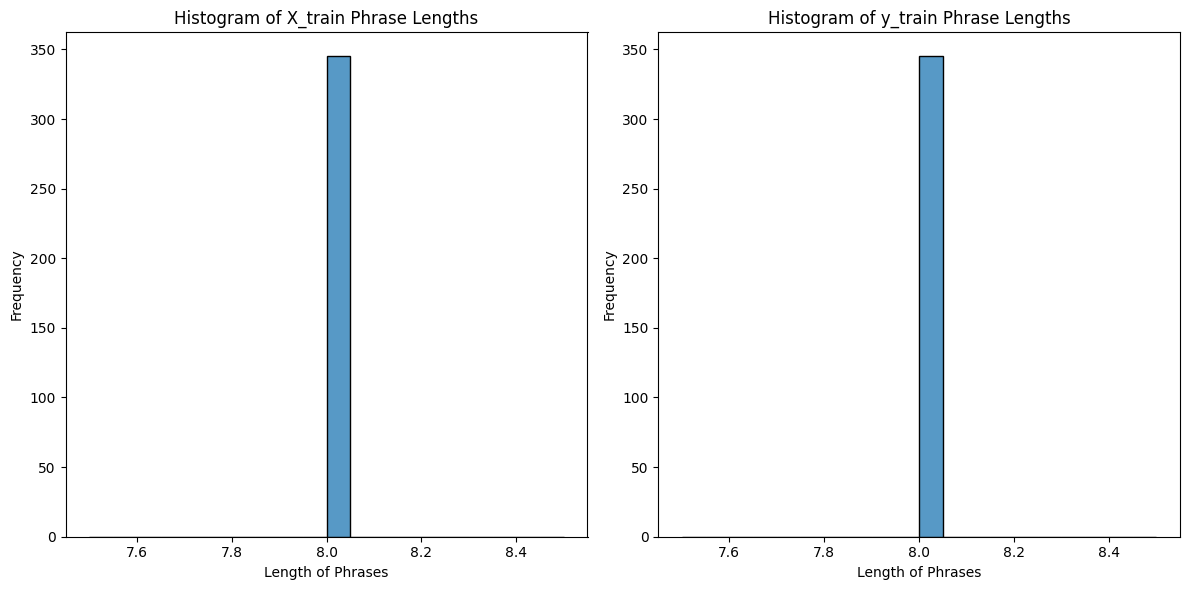

345 Chandler will pay for his coffee tomorrow .
vocabulary size 1060


In [38]:

import seaborn as sns
import matplotlib.pyplot as plt
min_v = 8
max_v = 8

def load_x_y_train_plain():
    with open('corpus/train.json', 'r', encoding='utf-8') as f:
        try:
            dataset = json.load(f)  # Load the JSON data

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
    X_train = []
    y_train = []

    # #Loop through the list and process each dialogue and summary
    for data in dataset:
        dialogue = data['dialogue']  # Split dialogue into a list of lines
        summary = data['summary']

        X_train.append(dialogue)
        y_train.append(summary)
    return X_train, y_train


def split_x_y_train(X_train, y_train):
    X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
    y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]
    return X_train, y_train


# with open('data/vocabolary_full.pkl', 'rb') as f:
#     vocabulary=pickle.load(f)
def filter_train_data(X_train, y_train, to_eliminate):
    filtered_X_train = []
    filtered_y_train = []

    for x, y in zip(X_train, y_train):
        if not any(to_eliminate_str in x for to_eliminate_str in to_eliminate):
            filtered_X_train.append(x)
            filtered_y_train.append(y)

    return filtered_X_train, filtered_y_train


def create_complete_vocabulary(X_train, y_train):
    nlp_model = spacy.load('en_core_web_lg')
    nlp_model.disable_pipes(["parser", "ner"])
    complete_text_target = ' '.join(y_train)
    complete_text_origin = ' '.join(X_train)
    complete_text = complete_text_target + " [START] [PAD] [END] " + complete_text_origin

    vocabulary = create_vocabulary(complete_text, "vocabolary_full", nlp_model)
    print("vocabulary size", len(vocabulary))
    return vocabulary


X_train, y_train = load_x_y_train_plain()
to_eliminate = [
    "[I hope I'm not coming off as rude - If I am, I'm sorry. I just thought it would be beneficial for the both of us...]",
    "[pulls back the curtain and checks out the window]",
    "[hopefully, masses of]"]
X_train, y_train = filter_train_data(X_train, y_train, to_eliminate)


sample = [i for i in range(0,len(y_train))]


X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]


X_train = [X_train[i] for i in sample if len(y_train[i]) <= max_v and len(y_train[i]) >= min_v]
y_train = [y_train[i] for i in sample if len(y_train[i]) <= max_v and len(y_train[i]) >= min_v]


# Calculate lengths of the tokenized phrases


def plot_lenghts(X_train,y_train):
    X_lengths = [len(x) for x in X_train]
    y_lengths = [len(y) for y in y_train]
    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Histogram for X_train lengths
    plt.subplot(1, 2, 1)
    sns.histplot(X_lengths, bins=20, kde=False)
    plt.title('Histogram of X_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Histogram for y_train lengths
    plt.subplot(1, 2, 2)
    sns.histplot(y_lengths, bins=20, kde=False)
    plt.title('Histogram of y_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()

X_train=[i[::-1] for i in y_train]
plot_lenghts(X_train,y_train)
 

X_train=[" ".join(x) for x in X_train]
y_train=[" ".join(y) for y in y_train]

print(len(y_train),y_train[0])

vocabulary=create_complete_vocabulary(X_train, y_train)

In [39]:
X_train[0],y_train[0]

('. tomorrow coffee his for pay will Chandler',
 'Chandler will pay for his coffee tomorrow .')

In [40]:
# learning_rate=0.001

# vocab_size=len(vocabulary)
# batch_size=1


# #batch_size = len(X_train)
# words_per_phrase = num_phrases= max_v
# dk = dv = embedding_size = 300 # constrain of transformer all embedding size both input embedding and attention embedding are the same encoder
# num_heads=10
# Qe = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Ke = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Ve = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Qc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Kc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Vc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Qd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Kd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Vd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)

# fl1_size=1024*2
# Wfl1e=cp.random.rand(embedding_size, fl1_size)
# bfl1e=cp.random.rand(fl1_size)

# Wfl2e=cp.random.rand(fl1_size, dv)
# bfl2e=cp.random.rand(dv)


# Wfl1d=cp.random.rand(embedding_size, fl1_size)
# bfl1d=cp.random.rand(fl1_size)

# Wfl2d=cp.random.rand(fl1_size, dv)
# bfl2d=cp.random.rand(dv)

# Wo=cp.random.rand(words_per_phrase*embedding_size,vocab_size)
# bo=cp.random.rand(vocab_size)


In [41]:
# fl1_size=1024*1 
# batch_size=32
# vocab_size=len(vocabulary) 
 
 
# words_per_phrase = num_phrases= max_v
# dk = dv = embedding_size = 300 # constrain of transformer all embedding size both input embedding and attention embedding are the same encoder
# num_heads=10

# num_batches_per_epoch = len(X_train) // batch_size
# num_epochs=550
# learning_rate=0.001

# Qe = linear_layer(embedding_size,embedding_size)
# Ke = linear_layer(embedding_size,embedding_size)
# Ve = linear_layer(embedding_size,embedding_size)
# linear_layer_econder_1=linear_layer(embedding_size,fl1_size)
# linear_layer_econder_2=linear_layer(fl1_size,embedding_size)

# normalization_layer_encoder_1=layer_normalization(epsilon=1e-6)
# relu_layer_encoder=ReLu_layer(alpha=0.001)
# normalization_layer_encoder_2=layer_normalization(epsilon=1e-6)
# multihead_attention_encoder=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
# multihead_cross_attention=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
# multihead_attention_decoder=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
# Qc = linear_layer(embedding_size,embedding_size)
# Kc = linear_layer(embedding_size,embedding_size)
# Vc = linear_layer(embedding_size,embedding_size)
# Qd = linear_layer(embedding_size,embedding_size)
# Kd = linear_layer(embedding_size,embedding_size)
# Vd = linear_layer(embedding_size,embedding_size)

# normalization_layer_decoder_1=layer_normalization(epsilon=1e-6)
# normalization_layer_decoder_2=layer_normalization(epsilon=1e-6)
# normalization_layer_decoder_3=layer_normalization(epsilon=1e-6)

# linear_layer_decoder_1=linear_layer(embedding_size,fl1_size)
# linear_layer_decoder_2=linear_layer(fl1_size,embedding_size)
# relu_layer_decoder=ReLu_layer(alpha=0.001)

# output_linear_layer=linear_layer(embedding_size,vocab_size)

 
 

In [42]:
def sparse_categorical_crossentropy(probabilities, labels):
    """
    Compute sparse categorical cross-entropy loss for next token prediction.
    
    Args:
        logits: Numpy array of shape (batch_size, num_classes), raw model outputs.
        labels: Numpy array of shape (batch_size,), integer-encoded labels of the next tokens.

    Returns:
        Scalar: The average cross-entropy loss across the batch.
    """
    # Step 1: Apply softmax to logits to get probabilities
     

    # Step 2: Extract probabilities for the correct class (target labels)
    batch_size = probabilities.shape[0]
    correct_class_probs = probabilities[np.arange(batch_size), labels]

    # Step 3: Compute the log of probabilities and then the negative log-likelihood
    loss = -np.log(correct_class_probs + 1e-8)  # Add small epsilon for numerical stability

    # Step 4: Return the average loss across the batch
    return np.mean(loss)

In [43]:
# learning_rate=0.0005
# Loss=0
# tot_loss_epoch=0
# for epoch in range(num_epochs):
#     print("Loss",tot_loss_epoch/num_batches_per_epoch)
#     tot_loss_epoch=0
#     for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         # try: 
#         start = i * batch_size
#         end = start + batch_size 
#         X_batch = X_train[start:end]
#         y_batch = y_train[start:end] 
#         inputs_e=create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
#         inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
#         Q_E=Qe.forward_weights_only(inputs_e)
#         K_E=Ke.forward_weights_only(inputs_e)
#         V_E=Ve.forward_weights_only(inputs_e) 
#         Q_E,K_E,V_E=multihead_attention_encoder.reshape_heads(Q_E,K_E,V_E)
#         Attention_weights_e=multihead_attention_encoder.attention_weights() 
#         Ae=multihead_attention_encoder.attention() 
#         Xe=inputs_e+Ae 
#         Ect1=normalization_layer_encoder_1.forward(Xe) 
#         Xe1=linear_layer_econder_1.forward(Ect1) 
#         FLe1=relu_layer_encoder.forward_leaky(Xe1) 
#         FLe1=dropout(FLe1, dropout_rate=0.1, training=True)
#         FLe2=linear_layer_econder_2.forward(FLe1)
#         Xe2=FLe2+Ect1
#         Ecout=normalization_layer_encoder_2.forward(Xe2)
        
#         #print("K_C.shape",K_C.shape)
#         #print("Ecout.shape",Ecout.shape,"inputs_e.shape",inputs_e.shape) 

#         target_d=pad_sequences(y_batch,lenght=words_per_phrase,target_type="target") 
#         target_d=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in target_d] 
#         tot_loss=0
#         counter_correct=0
#         for step in range(0,inputs_d.shape[0]):
#             inputs_decoder=inputs_d[step] 
#             #target_i=cp.array([get_one_hot(x[step], vocabulary) for x in target_d])

#             target_i=cp.array([vocabulary[x[step]][1] for x in target_d])
#             #print(target_i)
#             Q_D=Qd.forward_weights_only(inputs_decoder)
#             K_D=Kd.forward_weights_only(inputs_decoder)
#             V_D=Vd.forward_weights_only(inputs_decoder) 
#             Q_D,K_D,V_D=multihead_attention_decoder.reshape_heads(Q_D,K_D,V_D)
#             Attention_weights_masked=multihead_attention_decoder.attention_weights_masked(inputs_decoder.shape[1])
#             A_mask=multihead_attention_decoder.attention()
#             Xd=inputs_decoder+A_mask
#             Dt1=normalization_layer_decoder_1.forward(Xd)
#             Q_C=Qc.forward_weights_only(Dt1)
#             V_C=Vc.forward_weights_only(Ecout)
#             K_C=Kc.forward_weights_only(Ecout)
#             Q_C,K_C,V_C=multihead_cross_attention.reshape_heads(Q_C,K_C,V_C) 
#             Attention_weights_cross=multihead_cross_attention.attention_weights() 
#             Acr=multihead_cross_attention.attention()
#             Res=Acr+Dt1
#             Dt2=normalization_layer_decoder_2.forward(Res)
#             Xd1=linear_layer_decoder_1.forward(Dt2)
#             FLd1=relu_layer_decoder.forward_leaky(Xd1)
#             FLd1=dropout(FLd1, dropout_rate=0.1, training=True)
#             FLd2=linear_layer_decoder_2.forward(FLd1)
#             Xd2=FLd2+Dt2 
#             Dout=normalization_layer_decoder_3.forward(Xd2)
#             Dout = Dout[:, step, :]
#             #print("Dout",Dout.shape,"output_linear_layer",output_linear_layer.W.shape)
#             Zout=output_linear_layer.forward(Dout)
#             SigmaZout=softmax(Zout) 
#             #print(Zout) 
#             #print_vocabs(SigmaZout,vocabulary,y_batch,step,target_i,counter_correct)
#             Loss = sparse_categorical_crossentropy(SigmaZout, target_i)

#             #print(Loss) 
#             tot_loss+=Loss
#             #print("Loss",Loss)
#             #dLoss_dZout=SigmaZout-target_i
#             dLoss_dZout = SigmaZout.copy()  # Create a copy of the softmax output

#             # Subtract 1 for the true class indices
#             dLoss_dZout[np.arange(target_i.shape[0]), target_i] -= 1 
#             #print(dLoss_dZout)
             
#             dLoss_dWo=(dLoss_dZout.T@Dout).T
#             dLoss_dbo= cp.sum(dLoss_dZout,axis=0) 
#             #
 
#             dLoss_dDout=dLoss_dZout@output_linear_layer.W.T 
#             dLoss_dFLd2=cp.expand_dims(dLoss_dDout,axis=1)*normalization_layer_decoder_3.backpropagation()
#             dLoss_dDt2_a=dLoss_dFLd2
            
             
#             dLoss_dFLd1 = dLoss_dFLd2 @ linear_layer_decoder_2.W.T

            
#             dLoss_dWfl2d = cp.sum(cp.transpose(dLoss_dFLd2, (0, 2, 1)) @ FLd1, axis=0).T
#             dLoss_dbfl2d = cp.sum(cp.sum(dLoss_dFLd2, axis=0), axis=0)
#             #


            
#             DLoss_dDt2_b =relu_layer_decoder.backward_leaky(dLoss_dFLd1) @ cp.transpose(linear_layer_decoder_1.W, (1, 0))
#             DLoss_dDt2 = dLoss_dDt2_a + DLoss_dDt2_b
            
            
            
#             dLoss_dWfl1d = cp.sum(cp.transpose(relu_layer_decoder.backward_leaky(dLoss_dFLd1), (0, 2, 1)) @ Dt2, axis=0).T
#             dLoss_dbfl1d = cp.sum(cp.sum(relu_layer_decoder.backward_leaky(dLoss_dFLd1), axis=0), axis=0)
#             #
            
#             dLoss_dAcr = DLoss_dDt2 * normalization_layer_decoder_2.backpropagation()
#             dLoss_dDt1_a = dLoss_dAcr

            
#             dLoss_dQc = multihead_cross_attention.diffQi(dLoss_dAcr,Dt1)
#             #
             
#             dLoss_dKc=multihead_cross_attention.diffKi(dLoss_dAcr,Ecout)
#             #
             
#             dLoss_dVc=multihead_cross_attention.diffVi(dLoss_dAcr,Ecout)
#             #
            
#             dAttention_weights_cross = Attention_weights_cross * (1 - Attention_weights_cross)
#             dLoss_dDt1_b= dLoss_dAcr * redimension(dAttention_weights_cross @ (K_C * V_C / cp.sqrt(embedding_size))) @ Qc.W

#             dLoss_dDt1 = dLoss_dDt1_a + dLoss_dDt1_b
             
            
#             dLoss_Amask = dLoss_dDt1 * normalization_layer_decoder_1.backpropagation() 

#             dLoss_inputd_a = dLoss_Amask

#             dLoss_Kd=multihead_attention_decoder.diffKi(dLoss_Amask,inputs_decoder)
#             # 
#             dLoss_Qd =multihead_attention_decoder.diffQi(dLoss_Amask,inputs_decoder)
#             #
#             dLoss_Vd =multihead_attention_decoder.diffVi(dLoss_Amask,inputs_decoder)
#             #
            
           
            
#             dLoss_inputd_k=multihead_attention_decoder.diffKInput(dLoss_Amask,Kd.W)
#             dLoss_inputd_q=multihead_attention_decoder.diffQInput(dLoss_Amask,Qd.W)
#             dLoss_inputd_v=multihead_attention_decoder.diffVInput(dLoss_Amask,Vd.W)
#             dLoss_input_d = dLoss_inputd_a + dLoss_inputd_k + dLoss_inputd_q + dLoss_inputd_v
#             dLoss_dWemb_decoder= dLoss_input_d * inputs_decoder


#             output_linear_layer.update_weights(dLoss_dWo,dLoss_dbo,learning_rate)
#             linear_layer_decoder_2.update_weights(dLoss_dWfl2d,dLoss_dbfl2d,learning_rate)
#             linear_layer_decoder_1.update_weights(dLoss_dWfl1d,dLoss_dbfl1d,learning_rate)
#             Qc.update_weights_only(dLoss_dQc,learning_rate)
#             Kc.update_weights_only(dLoss_dKc,learning_rate)
#             Vc.update_weights_only(dLoss_dVc,learning_rate)
#             Kd.update_weights_only(dLoss_Kd,learning_rate)
#             Qd.update_weights_only(dLoss_Qd,learning_rate)
#             Vd.update_weights_only(dLoss_Vd,learning_rate)
#             inputs_decoder=inputs_decoder-learning_rate*dLoss_dWemb_decoder
#             vocabulary=update_wembedding_decoder(y_batch,inputs_decoder,words_per_phrase,vocabulary)

#         tot_loss_epoch+=tot_loss/inputs_d.shape[0]
#         #print(tot_loss/inputs_d.shape[0])
#         #dLoss_dFLe2 = dLoss_Ecout * diff_norm(Xe2, var_e2, mu_e2, N_e2)
        
         

#         dLoss_Ecout_k=multihead_cross_attention.diffKInput(dLoss_dAcr,Kc.W)
#         dLoss_Ecout_v=multihead_cross_attention.diffVInput(dLoss_dAcr,Vc.W)
#         dLoss_Ecout = dLoss_Ecout_k + dLoss_Ecout_v
#         #dLoss_dAcr = cp.swapaxes(cp.array(cp.array_split(dLoss_dAcr, num_heads, axis=2)), 0, 1)
        
        
#         #print("dLoss_Ecout",dLoss_Ecout_v.shape)

#         #dLoss_Ecout=derivative_Ecout(Attention_weights_cross,dLoss_dAcr,Q_C,V_C,Kc.W,Vc.W,num_heads)
         
#         dLoss_dFLe2 = dLoss_Ecout * normalization_layer_encoder_2.backpropagation()
#         dLoss_Ect1_a = dLoss_dFLe2

#         dLoss_dFLe1 = dLoss_dFLe2 @ linear_layer_econder_2.W.T

#         dLoss_dWfl2e = cp.sum(cp.transpose(dLoss_dFLe2, (0, 2, 1)) @ FLe1,axis=0).T
 
#         dLoss_dbfl2e = cp.sum(cp.sum(dLoss_dFLe2, axis=1),axis=0)
        

#         dLoss_Ect1_b = relu_layer_encoder.backward_leaky(dLoss_dFLe1) @ cp.transpose(linear_layer_econder_1.W, (1, 0))

#         dLoss_Ect1 = dLoss_Ect1_b + dLoss_Ect1_a
        
#         dLoss_dWfl1e = cp.sum(cp.transpose(relu_layer_encoder.backward_leaky(dLoss_dFLe1), (0, 2, 1)) @ Ect1,axis=0).T
        
#         dLoss_dbfl1e = cp.sum(cp.sum(relu_layer_encoder.backward_leaky(dLoss_dFLe1),axis=0),axis=0)

#         #print(dLoss_dbfl1e.shape,linear_layer_econder_1.b.shape)
#         dLoss_Ae = dLoss_Ect1 * normalization_layer_encoder_1.backpropagation()
        
#         dLoss_inpute_a = dLoss_Ae

#         dLoss_dQe=multihead_attention_encoder.diffQi(dLoss_Ae,inputs_e)

#         dLoss_dKe=multihead_attention_encoder.diffKi(dLoss_Ae, inputs_e)

#         dLoss_dVe=multihead_attention_encoder.diffVi(dLoss_Ae,inputs_e)
        
#         dLoss_inpute_k=multihead_attention_encoder.diffKInput(dLoss_Ae,Ke.W)
#         dLoss_inpute_q=multihead_attention_encoder.diffQInput(dLoss_Ae,Qe.W)
#         dLoss_inpute_v=multihead_attention_encoder.diffVInput(dLoss_Ae,Ve.W)
#         dLoss_input_e = dLoss_inpute_a + dLoss_inpute_k + dLoss_inpute_q + dLoss_inpute_v
#         dLoss_dWemb_encoder = dLoss_input_e * inputs_e

        
        
#         linear_layer_econder_2.update_weights(dLoss_dWfl2e,dLoss_dbfl2e,learning_rate)
#         linear_layer_econder_1.update_weights(dLoss_dWfl1e,dLoss_dbfl1e,learning_rate)

#         Qe.update_weights_only(dLoss_dQe,learning_rate)
#         Ke.update_weights_only(dLoss_dKe,learning_rate)
#         Ve.update_weights_only(dLoss_dVe,learning_rate)
      
#         inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
#         vocabulary=update_wembedding_encoder(X_batch,inputs_e,vocabulary,words_per_phrase)

#         # except Exception as e:
#         #     print(e)
#         #     traceback.print_exc()  

In [44]:
class Encoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,dropout_rate,batch_size,words_per_phrase):
        self.batch_size=batch_size
        self.words_per_phrase=words_per_phrase
        self.num_heads=num_heads
        self.dropout_rate=dropout_rate
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size
        self.Qe = linear_layer(self.embedding_size,self.embedding_size)
        self.Ke = linear_layer(self.embedding_size,self.embedding_size)
        self.Ve = linear_layer(self.embedding_size,self.embedding_size)
        self.linear_layer_econder_1=linear_layer(self.embedding_size,self.linear_layer_size)
        self.linear_layer_econder_2=linear_layer(self.linear_layer_size,self.embedding_size)
        self.multihead_attention_encoder=multihead_attention(num_heads=2,dk=embedding_size,batch_size=batch_size)
        self.normalization_layer_encoder_1=layer_normalization(epsilon=1e-6)
        self.relu_layer_encoder=ReLu_layer(alpha=0.01)
        self.normalization_layer_encoder_2=layer_normalization(epsilon=1e-6)
        self.projection_layer=linear_layer(self.embedding_size,self.embedding_size)
      

    def forward(self,inputs_e):
        self.inputs_e=inputs_e
        Q_E=self.Qe.forward_weights_only(self.inputs_e)
        K_E=self.Ke.forward_weights_only(self.inputs_e)
        V_E=self.Ve.forward_weights_only(self.inputs_e) 
        Q_E,K_E,V_E=self.multihead_attention_encoder.reshape_heads(Q_E,K_E,V_E)
        Ae=self.multihead_attention_encoder.attention() 
        Xe=self.inputs_e+Ae 
        Ect1=self.normalization_layer_encoder_1.forward(Xe) 
        Xe1=self.linear_layer_econder_1.forward(Ect1) 
        FLe1=self.relu_layer_encoder.forward_leaky(Xe1) 
        FLe1=dropout(FLe1, dropout_rate=self.dropout_rate, training=True)
        FLe2=self.linear_layer_econder_2.forward(FLe1)
        Xe2=FLe2+Ect1
        Ecout=self.normalization_layer_encoder_2.forward(Xe2)
        return Ecout


    def backpropagation(self,dLoss_Ecout,vocabulary,X_batch,learning_rate):
        
        dLoss_dFLe2 = dLoss_Ecout * self.normalization_layer_encoder_2.backpropagation()
        dLoss_Ect1_a = dLoss_dFLe2

        dLoss_dFLe1 = dLoss_dFLe2 @ self.linear_layer_econder_2.W.T

        dLoss_dWfl2e = cp.sum(cp.transpose(dLoss_dFLe2, (0, 2, 1)) @ self.linear_layer_econder_2.X,axis=0).T
 
        dLoss_dbfl2e = cp.sum(cp.sum(dLoss_dFLe2, axis=1),axis=0)
        

        dLoss_Ect1_b = self.relu_layer_encoder.backward_leaky(dLoss_dFLe1) @ cp.transpose(self.linear_layer_econder_1.W, (1, 0))

        dLoss_Ect1 = dLoss_Ect1_b + dLoss_Ect1_a
        
        dLoss_dWfl1e = cp.sum(cp.transpose(self.relu_layer_encoder.backward_leaky(dLoss_dFLe1), (0, 2, 1)) @ self.linear_layer_econder_1.X,axis=0).T
        
        dLoss_dbfl1e = cp.sum(cp.sum(self.relu_layer_encoder.backward_leaky(dLoss_dFLe1),axis=0),axis=0)

        #print(dLoss_dbfl1e.shape,linear_layer_econder_1.b.shape)
        dLoss_Ae = dLoss_Ect1 * self.normalization_layer_encoder_1.backpropagation()
        
        dLoss_inpute_a = dLoss_Ae

        dLoss_dQe=self.multihead_attention_encoder.diffQi(dLoss_Ae,self.inputs_e)

        dLoss_dKe=self.multihead_attention_encoder.diffKi(dLoss_Ae, self.inputs_e)

        dLoss_dVe=self.multihead_attention_encoder.diffVi(dLoss_Ae,self.inputs_e)
        
        dLoss_inpute_k=self.multihead_attention_encoder.diffKInput(dLoss_Ae,self.Ke.W)
        dLoss_inpute_q=self.multihead_attention_encoder.diffQInput(dLoss_Ae,self.Qe.W)
        dLoss_inpute_v=self.multihead_attention_encoder.diffVInput(dLoss_Ae,self.Ve.W)
        dLoss_input_e = dLoss_inpute_a + dLoss_inpute_k + dLoss_inpute_q + dLoss_inpute_v
        dLoss_dWemb_encoder = dLoss_input_e * self.inputs_e

        vocabulary=self.update_weights(dLoss_dWfl2e,
                                       dLoss_dbfl2e,
                                       dLoss_dWfl1e
                                       ,dLoss_dbfl1e,
                                       dLoss_dQe,
                                       dLoss_dKe,
                                       dLoss_dVe,dLoss_dWemb_encoder,vocabulary,X_batch,learning_rate)
        return vocabulary
    
    def update_weights(self,dLoss_dWfl2e,dLoss_dbfl2e,dLoss_dWfl1e,dLoss_dbfl1e,dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_dWemb_encoder,vocabulary,X_batch,learning_rate):
        self.linear_layer_econder_2.update_weights(dLoss_dWfl2e,dLoss_dbfl2e,learning_rate)
        self.linear_layer_econder_1.update_weights(dLoss_dWfl1e,dLoss_dbfl1e,learning_rate)

        self.Qe.update_weights_only(dLoss_dQe,learning_rate)
        self.Ke.update_weights_only(dLoss_dKe,learning_rate)
        self.Ve.update_weights_only(dLoss_dVe,learning_rate)
        self.inputs_e=self.inputs_e-learning_rate*dLoss_dWemb_encoder
        vocabulary=update_wembedding_encoder(X_batch,self.inputs_e,vocabulary,self.words_per_phrase)
        return vocabulary
    

class Decoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,dropout_rate,batch_size,words_per_phrase):
        self.words_per_phrase=words_per_phrase
        self.batch_size=batch_size
        self.num_heads=num_heads
        self.dropout_rate=dropout_rate
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size
        self.Qd = linear_layer(self.embedding_size,self.embedding_size)
        self.Kd = linear_layer(self.embedding_size,self.embedding_size)
        self.Vd = linear_layer(self.embedding_size,self.embedding_size)
        self.Qc = linear_layer(self.embedding_size,self.embedding_size)
        self.Kc = linear_layer(self.embedding_size,self.embedding_size)
        self.Vc = linear_layer(self.embedding_size,self.embedding_size)
        self.linear_layer_decoder_1=linear_layer(self.embedding_size,self.linear_layer_size)
        self.linear_layer_decoder_2=linear_layer(self.linear_layer_size,self.embedding_size)
        self.multihead_cross_attention=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
        self.multihead_attention_decoder=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
        self.normalization_layer_decoder_1=layer_normalization(epsilon=1e-6)
        self.relu_layer_decoder=ReLu_layer(alpha=0.01)
        self.normalization_layer_decoder_2=layer_normalization(epsilon=1e-6)
        self.normalization_layer_decoder_3=layer_normalization(epsilon=1e-6)
        

    def forward(self,inputs_decoder,Ecout):
        self.inputs_decoder=inputs_decoder
        Q_D=self.Qd.forward_weights_only(inputs_decoder)
        K_D=self.Kd.forward_weights_only(inputs_decoder)
        V_D=self.Vd.forward_weights_only(inputs_decoder) 
        Q_D,K_D,V_D=self.multihead_attention_decoder.reshape_heads(Q_D,K_D,V_D)
        A_mask=self.multihead_attention_decoder.masked_attention(inputs_decoder.shape[1])
        Xd=self.inputs_decoder+A_mask
        Dt1=self.normalization_layer_decoder_1.forward(Xd)
        Q_C=self.Qc.forward_weights_only(Dt1)
        V_C=self.Vc.forward_weights_only(Ecout)
        K_C=self.Kc.forward_weights_only(Ecout)
        Q_C,K_C,V_C=self.multihead_cross_attention.reshape_heads(Q_C,K_C,V_C)  
        Acr=self.multihead_cross_attention.attention()
        Res=Acr+Dt1
        Dt2=self.normalization_layer_decoder_2.forward(Res)
        Xd1=self.linear_layer_decoder_1.forward(Dt2)
        FLd1=self.relu_layer_decoder.forward_leaky(Xd1)
        FLd1=dropout(FLd1, dropout_rate=self.dropout_rate, training=True)
        FLd2=self.linear_layer_decoder_2.forward(FLd1)
        
        Xd2=FLd2+Dt2 
        
        Dout=self.normalization_layer_decoder_3.forward(Xd2)
        #print(Dout)
       
        #print(Dout)
        return Dout


    def backpropagation(self,dLoss_dDout,vocabulary,y_batch,learning_rate):
        
        #print("normalization_layer_decoder_3.backpropagation()",self.normalization_layer_decoder_3.backpropagation().shape) 
        #dLoss_dFLd2=cp.expand_dims(dLoss_dDout,axis=1)*self.normalization_layer_decoder_3.backpropagation()
        dLoss_dFLd2=dLoss_dDout*self.normalization_layer_decoder_3.backpropagation()
        dLoss_dDt2_a=dLoss_dFLd2
        
        #print("dLoss_dFLd2",dLoss_dFLd2.shape)    
        dLoss_dFLd1 = dLoss_dFLd2 @ self.linear_layer_decoder_2.W.T

        
        dLoss_dWfl2d = cp.sum(cp.transpose(dLoss_dFLd2, (0, 2, 1)) @ self.linear_layer_decoder_2.X, axis=0).T
        dLoss_dbfl2d = cp.sum(cp.sum(dLoss_dFLd2, axis=0), axis=0)
        
        DLoss_dDt2_b =self.relu_layer_decoder.backward_leaky(dLoss_dFLd1) @ cp.transpose(self.linear_layer_decoder_1.W, (1, 0))
        DLoss_dDt2 = dLoss_dDt2_a + DLoss_dDt2_b
         
        dLoss_dWfl1d = cp.sum(cp.transpose(self.relu_layer_decoder.backward_leaky(dLoss_dFLd1), (0, 2, 1)) @ self.linear_layer_decoder_1.X, axis=0).T
        dLoss_dbfl1d = cp.sum(cp.sum(self.relu_layer_decoder.backward_leaky(dLoss_dFLd1), axis=0), axis=0)
        # 
        dLoss_dAcr = DLoss_dDt2 * self.normalization_layer_decoder_2.backpropagation()
        dLoss_dDt1_a = dLoss_dAcr
 
        dLoss_dQc = self.multihead_cross_attention.diffQi(dLoss_dAcr,self.Qc.X)
         
        dLoss_dKc=self.multihead_cross_attention.diffKi(dLoss_dAcr,self.Kc.X)
         
        dLoss_dVc=self.multihead_cross_attention.diffVi(dLoss_dAcr,self.Vc.X)
         
        dAttention_weights_cross = self.multihead_cross_attention.Attention_weights * (1 - self.multihead_cross_attention.Attention_weights)

        dLoss_dDt1_b= dLoss_dAcr * redimension(dAttention_weights_cross @ (self.multihead_cross_attention.K * self.multihead_cross_attention.V / cp.sqrt(embedding_size))) @ self.Qc.W

        dLoss_dDt1 = dLoss_dDt1_a + dLoss_dDt1_b
           
        dLoss_Amask = dLoss_dDt1 * self.normalization_layer_decoder_1.backpropagation() 

        dLoss_inputd_a = dLoss_Amask

        dLoss_Kd=self.multihead_attention_decoder.diffKi(dLoss_Amask,self.inputs_decoder)
        # 
        dLoss_Qd =self.multihead_attention_decoder.diffQi(dLoss_Amask,self.inputs_decoder)
        #
        dLoss_Vd =self.multihead_attention_decoder.diffVi(dLoss_Amask,self.inputs_decoder)
        #
        dLoss_inputd_k=self.multihead_attention_decoder.diffKInput(dLoss_Amask,self.Kd.W)
        dLoss_inputd_q=self.multihead_attention_decoder.diffQInput(dLoss_Amask,self.Qd.W)
        dLoss_inputd_v=self.multihead_attention_decoder.diffVInput(dLoss_Amask,self.Vd.W)
        dLoss_input_d = dLoss_inputd_a + dLoss_inputd_k + dLoss_inputd_q + dLoss_inputd_v
        dLoss_dWemb_decoder= dLoss_input_d * self.inputs_decoder

        vocabulary=self.update_weights(dLoss_dWfl2d,
                                        dLoss_dbfl2d,
                                        dLoss_dWfl1d,
                                        dLoss_dbfl1d,
                                        dLoss_dQc,
                                        dLoss_dKc,
                                        dLoss_dVc,
                                        dLoss_Kd,
                                        dLoss_Qd,
                                        dLoss_Vd,
                                        dLoss_dWemb_decoder,
                                        vocabulary,
                                        y_batch,
                                        learning_rate)
        return vocabulary,dLoss_dAcr
    
    def update_weights(self,dLoss_dWfl2d,
                       dLoss_dbfl2d,
                       dLoss_dWfl1d,
                       dLoss_dbfl1d,
                       dLoss_dQc,
                       dLoss_dKc,
                       dLoss_dVc,
                       dLoss_Kd,
                       dLoss_Qd,
                       dLoss_Vd,
                       dLoss_dWemb_decoder,
                       vocabulary,
                       y_batch,
                       learning_rate):
        self.linear_layer_decoder_2.update_weights(dLoss_dWfl2d,dLoss_dbfl2d,learning_rate)
        self.linear_layer_decoder_1.update_weights(dLoss_dWfl1d,dLoss_dbfl1d,learning_rate)
        self.Qc.update_weights_only(dLoss_dQc,learning_rate)
        self.Kc.update_weights_only(dLoss_dKc,learning_rate)
        self.Vc.update_weights_only(dLoss_dVc,learning_rate)
        self.Kd.update_weights_only(dLoss_Kd,learning_rate)
        self.Qd.update_weights_only(dLoss_Qd,learning_rate)
        self.Vd.update_weights_only(dLoss_Vd,learning_rate)
        self.inputs_decoder=self.inputs_decoder-learning_rate*dLoss_dWemb_decoder
        vocabulary=update_wembedding_decoder(y_batch,self.inputs_decoder,self.words_per_phrase,vocabulary) 
        return vocabulary


In [45]:
# fl1_size=1024*1 
# batch_size=32
# vocab_size=len(vocabulary) 
 
 
# words_per_phrase = num_phrases= max_v
# dk = dv = embedding_size = 300 # constrain of transformer all embedding size both input embedding and attention embedding are the same encoder
# num_heads=10

# num_batches_per_epoch = len(X_train) // batch_size
# num_epochs=550
# learning_rate=0.001

# Qe = linear_layer(embedding_size,embedding_size)
# Ke = linear_layer(embedding_size,embedding_size)
# Ve = linear_layer(embedding_size,embedding_size)
# linear_layer_econder_1=linear_layer(embedding_size,fl1_size)
# linear_layer_econder_2=linear_layer(fl1_size,embedding_size)

# normalization_layer_encoder_1=layer_normalization(epsilon=1e-6)
# relu_layer_encoder=ReLu_layer(alpha=0.01)
# normalization_layer_encoder_2=layer_normalization(epsilon=1e-6)
# multihead_attention_encoder=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
# multihead_cross_attention=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
# multihead_attention_decoder=multihead_attention(num_heads=num_heads,dk=embedding_size,batch_size=batch_size)
# Qc = linear_layer(embedding_size,embedding_size)
# Kc = linear_layer(embedding_size,embedding_size)
# Vc = linear_layer(embedding_size,embedding_size)
# Qd = linear_layer(embedding_size,embedding_size)
# Kd = linear_layer(embedding_size,embedding_size)
# Vd = linear_layer(embedding_size,embedding_size)

# normalization_layer_decoder_1=layer_normalization(epsilon=1e-6)
# normalization_layer_decoder_2=layer_normalization(epsilon=1e-6)
# normalization_layer_decoder_3=layer_normalization(epsilon=1e-6)

# linear_layer_decoder_1=linear_layer(embedding_size,fl1_size)
# linear_layer_decoder_2=linear_layer(fl1_size,embedding_size)
# relu_layer_decoder=ReLu_layer(alpha=0.01)




In [46]:
# vocabulary["[PAD]"]=(cp.zeros(embedding_size),vocabulary["[PAD]"][1])
vocabulary["[PAD]"]

(array([7.29, -4.52, 6.58, -2.67, -1.89, 1.38, 4.31, -3.22, -10.3, -1.86, -0.165, -2.48, 9.21, 0.397, 1.59, 7.13, -6.91, 4.72, -1.58, -0.172, 4.32, 3.8, 1.43, -5.23, -7.19, 1.69, 4.76, 6.03, -3.68, -4.43, -0.472, -1.38, 6.1, 2.23, 0.887, -5.05, -1.16, 0.472, 6.07, 6.63, 1.5, -2.8, -7.84, 8.3, 2.25, -13.7, 4.49, 1.6, 3.39, -6.48, -7.28, -0.184, -2.28, -3.54, -4.86, 4.98, 6.52, -3.3, 7.13, -2.69, -0.978, -2.03, -4.34, -0.0675, -4.21, 3.58, -9.06, 0.371, 0.468, 1.56, 0.745, -5.18, -5.34, -5.32, -0.718, 0.632, 1.63, 3.74, -2.94, 5.61, -0.722, -3.61, -3.2, -1.7, -5.03, -1.62, 1.89, -1.64, 6.58, 2.95, -10.6, 1.52, -6.33, -7.92, -5.77, 4.34, -0.0952, -1.63, -0.553, -0.957, 0.99, -2.37, 3.49, -3.04, 1.74, 4.95, 11.8, 0.265, -4.32, 5.9, 3.63, 0.339, 2.86, -1.67, -1.76, 0.766, -3.32, 4.36, -0.622, -1.46, 4.53, 1.96, 0.922, -0.981, 2.86, 2.27, 2.65, 1.67, 0.0472, -3.75, -6.28, -1.6, 2.4, -0.826, 4.83, -6, -0.0516, 1.95, -1.24, 4.48, -3.47, -0.587, -5.91, 3.51, -4.78, -0.428, -4.84, 0.476, 10.3, 1

In [47]:
a=vocabulary["[PAD]"][0]
b=vocabulary["[PAD]"][0]
a.all()==b.all()

array(True)

In [48]:
import traceback
words_per_phrase = num_phrases= max_v
embedding_size=300
fl1_size=3048
learning_rate=0.001
batch_size=4
num_heads=10
dropout_rate=0.2
TransformerEncoder=Encoder(embedding_size,num_heads,fl1_size,dropout_rate=dropout_rate,batch_size=batch_size,words_per_phrase=max_v)
TransformerDecoder=Decoder(embedding_size,num_heads,fl1_size,dropout_rate=dropout_rate,batch_size=batch_size,words_per_phrase=max_v)
output_linear_layer=linear_layer(embedding_size,len(vocabulary),out=True)  
num_batches_per_epoch = len(X_train) // batch_size
num_epochs=550
tot_loss_epoch=0

In [54]:

for epoch in range(100):
    print("Loss",tot_loss_epoch/num_batches_per_epoch)
    tot_loss_epoch=0
    for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
        try: 
            start = i * batch_size
            end = start + batch_size 
            X_batch = X_train[start:end]
            y_batch = y_train[start:end] 
            #print(y_batch)
            inputs_e=create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
            inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
            Ecout=TransformerEncoder.forward(inputs_e)
             
            
            #print("Ecout.shape",Ecout.shape,"inputs_e.shape",inputs_e.shape) 
 
            #target_d=pad_sequences(y_batch,lenght=words_per_phrase,target_type="target") 
            #target_d=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in target_d] 
            tot_loss=0
            totdLoss_dAcr=0
            counter_correct=0
            target_d=create_decoder_target(y_batch,embedding_size,words_per_phrase,vocabulary) 
            print("inputs_d.shape",inputs_d.shape)
            print("inputs_e.shape",inputs_e.shape)
            print("target_d.shape",target_d.shape)
          
                
            Dout = TransformerDecoder.forward(target_d,Ecout)
            #print("Dout",Dout.shape,"output_linear_layer",output_linear_layer.W.shape)
            Zout=output_linear_layer.forward(Dout)
            
            #print("Zout.shape",Zout.shape)
            SigmaZout=softmax(Zout) 
            # print("SigmaZout.shape",SigmaZout.shape)
            # print("target_i.shape",target_i.shape)
            # print("inputs_decoder.shape",inputs_decoder.shape)
        #     # for nn in SigmaZout:
        #     #     print(np.argmax(nn)) 
            #print_vocabs(SigmaZout,vocabulary,y_batch,step,target_i,counter_correct)
            #print_accuracy(SigmaZout, vocabulary,inputs_decoder,step,target_i,counter_correct)
            Loss = cross_entropy_loss(SigmaZout, target_d,vocabulary)
            #print(Loss) 
            tot_loss+=Loss 
            dLoss_dZout=SigmaZout-target_i
            #print("dLoss_dZout.shape",dLoss_dZout.shape)
            # dLoss_dZout = SigmaZout.copy()  # Create a copy of the softmax output 
            # dLoss_dZout[np.arange(target_i.shape[0]), target_i] -= 1 
            #clip_value = 1.0
            #dLoss_dZout = cp.clip(dLoss_dZout, -clip_value, clip_value) 
            dLoss_Wo=cp.sum(cp.transpose(dLoss_dZout,(0,2,1))@Dout,axis=0).T
            dLoss_bo=cp.sum(cp.sum(dLoss_dZout,axis=0),axis=0) 
            dLoss_dDout=dLoss_dZout@output_linear_layer.W.T  
            vocabulary,dLoss_dAcr=TransformerDecoder.backpropagation(dLoss_dDout,vocabulary,y_batch,learning_rate)
            output_linear_layer.update_weights(dLoss_Wo,dLoss_bo,learning_rate)
            totdLoss_dAcr+=dLoss_dAcr

            # #totdLoss_dAcr=totdLoss_dAcr/inputs_d.shape[0]
            # dLoss_dAcr=totdLoss_dAcr
            tot_loss_epoch+=tot_loss/inputs_d.shape[0] 
            dLoss_Ecout_k=TransformerDecoder.multihead_cross_attention.diffKInput(totdLoss_dAcr,TransformerDecoder.Kc.W)
            dLoss_Ecout_v=TransformerDecoder.multihead_cross_attention.diffVInput(totdLoss_dAcr,TransformerDecoder.Vc.W)
            dLoss_Ecout = dLoss_Ecout_k + dLoss_Ecout_v 
            
            vocabulary=TransformerEncoder.backpropagation(dLoss_Ecout,vocabulary,X_batch,learning_rate)
            

        except Exception as e:
            print(e)
            traceback.print_exc()  

Loss 0.0


Epoch 1/550:   0%|          | 0/86 [00:00<?, ?it/s]Traceback (most recent call last):
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1330844885.py", line 29, in <module>
    Dout = TransformerDecoder.forward(target_d,Ecout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\3679559859.py", line 123, in forward
    Q_D=self.Qd.forward_weights_only(inputs_decoder)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1670094454.py", line 443, in forward_weights_only
    Xout = cp.matmul(X, self.W)
          ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\_gufuncs.py", line 658, in __call__
    args, dimsizess, loop_output_dims, outs, m_dims = self._get_args_transposed(  # NOQA
                                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs f

inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different le

Traceback (most recent call last):
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1330844885.py", line 29, in <module>
    Dout = TransformerDecoder.forward(target_d,Ecout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\3679559859.py", line 123, in forward
    Q_D=self.Qd.forward_weights_only(inputs_decoder)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1670094454.py", line 443, in forward_weights_only
    Xout = cp.matmul(X, self.W)
          ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\_gufuncs.py", line 658, in __call__
    args, dimsizess, loop_output_dims, outs, m_dims = self._get_args_transposed(  # NOQA
                                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\

inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different le

Traceback (most recent call last):
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1330844885.py", line 29, in <module>
    Dout = TransformerDecoder.forward(target_d,Ecout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\3679559859.py", line 123, in forward
    Q_D=self.Qd.forward_weights_only(inputs_decoder)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1670094454.py", line 443, in forward_weights_only
    Xout = cp.matmul(X, self.W)
          ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\_gufuncs.py", line 658, in __call__
    args, dimsizess, loop_output_dims, outs, m_dims = self._get_args_transposed(  # NOQA
                                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\

inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different le

Traceback (most recent call last):
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1330844885.py", line 29, in <module>
    Dout = TransformerDecoder.forward(target_d,Ecout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\3679559859.py", line 123, in forward
    Q_D=self.Qd.forward_weights_only(inputs_decoder)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dials\AppData\Local\Temp\ipykernel_13476\1670094454.py", line 443, in forward_weights_only
    Xout = cp.matmul(X, self.W)
          ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\_gufuncs.py", line 658, in __call__
    args, dimsizess, loop_output_dims, outs, m_dims = self._get_args_transposed(  # NOQA
                                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dials\Desktop\LLMs from scratch\spacy_env\Lib\site-packages\cupy\_core\

inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different lengths in arrays
inputs_d.shape (4, 8, 300)
inputs_e.shape (4, 8, 300)
target_d.shape (4, 8, 1060)
Dimension k with different le

KeyboardInterrupt: 

In [ ]:
vocabulary["[PAD]"]

In [ ]:
for i in [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in y_batch][0]:
    print(i,vocabulary[i])


In [ ]:
target_d[2]

In [195]:
# learning_rate=0.001

# vocab_size=len(vocabulary)
# batch_size=32


# #batch_size = len(X_train)
# words_per_phrase = num_phrases= max_v
# dk = dv = embedding_size = 300 # constrain of transformer all embedding size both input embedding and attention embedding are the same encoder
# num_heads=5
# Qe = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Ke = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Ve = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Qc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Kc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Vc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Qd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Kd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
# Vd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)

# fl1_size=1024*2
# Wfl1e=cp.random.rand(embedding_size, fl1_size)
# bfl1e=cp.random.rand(fl1_size)

# Wfl2e=cp.random.rand(fl1_size, dv)
# bfl2e=cp.random.rand(dv)


# Wfl1d=cp.random.rand(embedding_size, fl1_size)
# bfl1d=cp.random.rand(fl1_size)

# Wfl2d=cp.random.rand(fl1_size, dv)
# bfl2d=cp.random.rand(dv)

# Wo=cp.random.rand(embedding_size,vocab_size)* cp.sqrt(1 / (words_per_phrase * embedding_size))
# bo=cp.random.rand(vocab_size)

In [196]:
# import traceback
 
# #X_train,y_train=load_x_y_train_plain()
# num_batches_per_epoch = len(X_train) // batch_size
# num_epochs=550
# learning_rate=0.01
# tot_loss_epoch=0
# for epoch in range(num_epochs):
#     print("Loss",tot_loss_epoch/num_batches_per_epoch)
#     tot_loss_epoch=0
#     for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
#         try: 
#             start = i * batch_size
#             end = start + batch_size 
#             X_batch = X_train[start:end]
#             y_batch = y_train[start:end] 
#             inputs_e=create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
#             inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
           
#             Ae,Attention_weights_e,K_E,V_E,Q_E=forward_attention_encoder(inputs_e,Qe, Ke, Ve, num_heads, batch_size, dk)

#             Ect1,Xe,mu_e,var_e,Ne=residual_and_norm(Ae,inputs_e) 
#             #print("Ecout.shape",Ect1.shape)
#             Ecout,mu_e2,var_e2,N_e2,FLe1,Xe1,Xe2=fully_connected_layers_encoder(Ect1,Wfl1e, bfl1e, Wfl2e, bfl2e)
            
#             K_C,V_C=cross_attention_encoder(Ecout)
#             #K_C,V_C=cross_attention_encoder(Ect1)

#             clip_value = 1500
#             #print("K_C.shape",K_C.shape)
#             #print("V_C.shape",V_C.shape)
#             target_d=pad_sequences(y_batch,lenght=words_per_phrase,target_type="target")
            
#             target_d=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in target_d] 
#             #print_matrix(target_d)
#             tot_loss=0
#             counter_correct=0
#             ct_max=0
#             for step in range(0,inputs_d.shape[0]):
#                 inputs_decoder=inputs_d[step]
#                 #print([x[step]  for x in target_d])
#                 target=cp.array([get_one_hot(x[step], vocabulary) for x in target_d])
#                 #print(target)

#                 A_mask,Attention_weights_masked,Q_D,K_D,V_D=forward_attention_decoder(inputs_decoder)

#                 Xd,Dt1,mu_d,var_d,N_d=decoder_first_residual_and_norm(A_mask,inputs_decoder)

#                 Q_C=cross_attention_decoder(Dt1)
#                 #print("Q_C.shape",Q_C.shape)
#                 Acr,Attention_weights_cross=cross_attention(Q_C,K_C,V_C,Dt1)

#                 Dt2, mu_res,var_res,N_res,Res= cross_attention_residual_and_norm(Acr ,Dt1)
                
#                 Dout,mu_d2,var_d2,N_d2,Xd2,Xd1,FLd1=fully_connected_layers_decoder(Dt2)

#                 #Dt2=Dt2.reshape(Dt2.shape[0],Dt2.shape[1]*Dt2.shape[2])
#                 Dout=Dout[:, step, :]
#                 #print(Dout.shape,Dt2.shape)
#                 SigmaZout=output_layer(Dout)
#                 #SigmaZout=output_layer(Dt2)
                
#                 print(SigmaZout.shape)
#                 #counter=print_vocabs(SigmaZout,vocabulary,y_batch,step,target,counter_correct)

#                 # if counter>ct_max: 
#                 #     ct_max=counter
#                     #print(counter)
#                 Loss=loss_calculation(SigmaZout,target)


#                 tot_loss+=Loss


#                 #print("step",step,"Loss",Loss)



#                 dLoss_dZout,dLoss_Dout,dLoss_W0,dLoss_b0=derivate_dout(SigmaZout,target,Dout)
#                 #dLoss_dZout,dLoss_Dout,dLoss_W0,dLoss_b0=derivate_dout(SigmaZout,target,Dt2)
#                 dLoss_Wfl2d,dLoss_bfl2d,dLoss_Wfl1d,dLoss_bfl1d,DLoss_Dt2=derivate_fully_connected_layers_decoder(dLoss_Dout,Dt2,Xd2,var_d2,mu_d2,N_d2,FLd1,Xd1)
#                 #dLoss_Qc,dLoss_Kc,dLoss_Vc,Attention_weights_cross,dLoss_Dt1_a,dLoss_Acr=derivative_cross_attention(DLoss_Dt2,Res,var_res,mu_res,N_res,Attention_weights_cross,K_C,V_C,Q_C,Ect1,Dt1)
#                 dLoss_Qc,dLoss_Kc,dLoss_Vc,Attention_weights_cross,dLoss_Dt1_a,dLoss_Acr=derivative_cross_attention(DLoss_Dt2,Res,var_res,mu_res,N_res,Attention_weights_cross,K_C,V_C,Q_C,Ecout,Dt1)

#                 dLoss_Kd,dLoss_Qd,dLoss_Vd,dLoss_inputd_a,dLoss_Amask=derivative_attention_decoder(dLoss_Acr,Attention_weights_cross,dLoss_Dt1_a,Attention_weights_masked,Q_D,V_D,K_D,K_C,V_C,Xd,var_d,mu_d,N_d,inputs_decoder)
#                 dLoss_inputd,dLoss_dWemb_decoder=derivative_input_decoder(dLoss_Amask,Attention_weights_masked,K_D,V_D,Q_D,dLoss_inputd_a,inputs_decoder)


#                 dLoss_W0 = cp.clip(dLoss_W0, -clip_value, clip_value)
#                 dLoss_b0 = cp.clip(dLoss_b0, -clip_value, clip_value)
#                 dLoss_Wfl2d = cp.clip(dLoss_Wfl2d, -clip_value, clip_value)
#                 dLoss_bfl2d = cp.clip(dLoss_bfl2d, -clip_value, clip_value)
#                 dLoss_Wfl1d = cp.clip(dLoss_Wfl1d, -clip_value, clip_value)
#                 dLoss_bfl1d = cp.clip(dLoss_bfl1d, -clip_value, clip_value)
                
#                 dLoss_Qc = cp.clip(dLoss_Qc, -clip_value, clip_value)
#                 dLoss_Kc = cp.clip(dLoss_Kc, -clip_value, clip_value)
#                 dLoss_Vc = cp.clip(dLoss_Vc, -clip_value, clip_value)
#                 dLoss_Qd = cp.clip(dLoss_Qd, -clip_value, clip_value)
#                 dLoss_Kd = cp.clip(dLoss_Kd, -clip_value, clip_value)
#                 dLoss_Vd = cp.clip(dLoss_Vd, -clip_value, clip_value)
#                 dLoss_dWemb_decoder = cp.clip(dLoss_dWemb_decoder, -clip_value, clip_value)

#                 Wo=Wo-learning_rate*dLoss_W0.T
#                 bo=bo-learning_rate*dLoss_b0
#                 Wfl2d=Wfl2d-learning_rate*dLoss_Wfl2d
#                 bfl2d=bfl2d-learning_rate*dLoss_bfl2d
#                 Wfl1d=Wfl1d-learning_rate*dLoss_Wfl1d
#                 bfl1d=bfl1d-learning_rate*dLoss_bfl1d
#                 Qc=Qc-learning_rate*dLoss_Qc
#                 Kc=Kc-learning_rate*dLoss_Kc
#                 Vc=Vc-learning_rate*dLoss_Vc
#                 Qd=Qd-learning_rate*dLoss_Qd
#                 Kd=Kd-learning_rate*dLoss_Kd
#                 Vd=Vd-learning_rate*dLoss_Vd
#                 inputs_decoder=inputs_decoder-learning_rate*dLoss_dWemb_decoder
#                 vocabulary=update_wembedding_decoder(y_batch,inputs_decoder,words_per_phrase,vocabulary)

#                 #print_vocabs(SigmaZout,vocabulary,y_batch,step,target,counter_correct)

#             #print("Loss",tot_loss/inputs_d.shape[0])
#             tot_loss_epoch+=tot_loss/inputs_d.shape[0]


#             dLoss_Ecout=derivative_Ecout(Attention_weights_cross,dLoss_Acr,Q_C,V_C)
            
#             dLoss_dWfl2e,dLoss_dbfl2e,dLoss_Wfl1e,dLoss_bfl1e,dLoss_Ect1=derivate_fully_connected_layers_encoder(dLoss_Ecout,Ect1,Xe2,var_e2,mu_e2,N_e2,FLe1,Xe1)

#             #dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_inpute_a,dLoss_Ae=derivative_attention_encoder(dLoss_Ect1,Xe,var_e,mu_e,Ne,Attention_weights_e,K_E,V_E,Q_E,inputs_e)
#             dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_inpute_a,dLoss_Ae=derivative_attention_encoder(dLoss_Ecout,Xe,var_e,mu_e,Ne,Attention_weights_e,K_E,V_E,Q_E,inputs_e)

#             dLoss_inpute,dLoss_dWemb_encoder=derivative_input_encoder(dLoss_Ae,Attention_weights_e,K_E,V_E,Q_E,dLoss_inpute_a,inputs_e)

#             dLoss_dWfl2e = cp.sum(cp.transpose(dLoss_dWfl2e ,(0,2,1)),axis=0) 
#             dLoss_dWfl2e = cp.clip(dLoss_dWfl2e, -clip_value, clip_value)
#             dLoss_dbfl2e = cp.sum(dLoss_dbfl2e ,axis=0) 
#             dLoss_dbfl2e = cp.clip(dLoss_dbfl2e, -clip_value, clip_value)
#             dLoss_Wfl1e = cp.sum(cp.transpose(dLoss_Wfl1e ,(0,2,1)),axis=0) 
#             dLoss_Wfl1e = cp.clip(dLoss_Wfl1e, -clip_value, clip_value)
#             dLoss_bfl1e = cp.sum(cp.transpose(dLoss_bfl1e ,(0,2,1)),axis=0) 
#             dLoss_bfl1e = cp.clip(dLoss_bfl1e, -clip_value, clip_value)
#             dLoss_dQe = cp.clip(dLoss_dQe, -clip_value, clip_value)
#             dLoss_dKe = cp.clip(dLoss_dKe, -clip_value, clip_value)
#             dLoss_dVe = cp.clip(dLoss_dVe, -clip_value, clip_value)
#             dLoss_dWemb_encoder = cp.clip(dLoss_dWemb_encoder, -clip_value, clip_value)
#             Wfl2e=Wfl2e-learning_rate*dLoss_dWfl2e
#             bfl2e=bfl2e-learning_rate*dLoss_dbfl2e
#             Wfl1e=Wfl1e-learning_rate*dLoss_Wfl1e  #print(dLoss_bfl1e.shape,cp.sum(dLoss_bfl1e,axis=0).shape,bfl1e.shape,cp.sum(cp.transpose(dLoss_bfl1e ,(0,2,1)),axis=0).shape)
#             bfl1e=bfl1e-learning_rate*dLoss_bfl1e
#             Qe=Qe-learning_rate*dLoss_dQe
#             Ke=Ke-learning_rate*dLoss_dKe
#             Ve=Ve-learning_rate*dLoss_dVe
#             inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
#             vocabulary=update_wembedding_encoder(X_batch,inputs_e,vocabulary,words_per_phrase)
#         except Exception as e:
#             print(e)
#             traceback.print_exc()
#             pass
#     #inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
